<a href="https://colab.research.google.com/github/Searching96/global-unposted-prediction/blob/main/global_unposted_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn==1.6.1

# 1. SETUP & MOUNT GOOGLE DRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

print("✓ Google Drive mounted successfully")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted successfully


# 2. INSTALL & IMPORT LIBRARIES

In [ ]:
!pip install lightgbm -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder

import pickle
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [ ]:
import sklearn
print(f"sklearn version: {sklearn.__version__}")

sklearn version: 1.6.1


# 3. LOAD DATA FROM GOOGLE DRIVE

In [ ]:
print("\n" + "="*80)
print("LOADING DATA")
print("="*80)

# Load data
data_path = '/content/drive/MyDrive/global_unposted_prediction/processed_video_data_caption_inferred.csv'
df = pd.read_csv(data_path, keep_default_na=False)

print(f"✓ Data loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

# Check data info
print(f"\nData Info:")
print(df.info())

# Check missing values
print(f"\nMissing values:")
print(df.isnull().sum())

df_clean = df.copy()


LOADING DATA
✓ Data loaded: 7015 rows, 32 columns

Columns: ['video_id', 'kol_id', 'days_since_posted', 'current_views', 'current_likes', 'current_shares', 'current_comments', 'engagement_rate', 'avg_views_3m', 'median_views_3m', 'std_views_3m', 'avg_likes_3m', 'avg_shares_3m', 'avg_comments_3m', 'engagement_rate_3m', 'like_rate_3m', 'share_rate_3m', 'comment_rate_3m', 'post_frequency_3m', 'trend_views_1m_vs_3m', 'num_followers', 'video_length', 'diversification_labels', 'day_of_week', 'hour_of_day', 'raw_caption', 'caption', 'curiosity', 'controversy', 'utility', 'emotion', 'urgency']

First few rows:
              video_id           kol_id  days_since_posted  current_views  \
0  7559512445660744968  anhsonn_fitness                 89          18400   
1  7559909217000295688  anhsonn_fitness                 88          71000   
2  7560653226152889608  anhsonn_fitness                 86          20300   
3  7560994146618592519  anhsonn_fitness                 85         397300   
4  7

# 4. DATA PREPROCESSING

In [ ]:
import pandas as pd
import numpy as np

def create_time_series_features(df):
    """
    Tạo Lag Features.
    Xử lý NaN: Thay vì điền 0, sẽ điền bằng Median/Avg 3 tháng của kênh đó.
    """
    print(">>> Feature Engineering: Creating Lag Features...")

    # Copy để không ảnh hưởng dataframe gốc
    df_ts = df.copy()

    # 1. SẮP XẾP: Kênh -> Ngày đăng (Cũ lên trên, Mới xuống dưới)
    # days_since_posted càng LỚN thì là video càng CŨ -> Sort GIẢM DẦN
    df_ts = df_ts.sort_values(by=['kol_id', 'days_since_posted'], ascending=[True, False])

    # 2. TẠO LAG (Dịch chuyển dữ liệu)
    # Lag 1: View của video ngay trước đó
    df_ts['lag_view_1'] = df_ts.groupby('kol_id')['current_views'].shift(1)

    # Lag 2: View của video cách đó 2 bài
    df_ts['lag_view_2'] = df_ts.groupby('kol_id')['current_views'].shift(2)

    # Rolling Mean: Trung bình view của 3 video gần nhất
    df_ts['roll_mean_views_3'] = df_ts.groupby('kol_id')['current_views'].transform(
        lambda x: x.shift(1).rolling(window=3).mean()
    )

    # Lag Like: Like của video trước đó
    df_ts['lag_like_1'] = df_ts.groupby('kol_id')['current_likes'].shift(1)

    # 3. XỬ LÝ MISSING DATA (Điền bằng lịch sử thay vì số 0)
    view_cols = ['lag_view_1', 'lag_view_2', 'roll_mean_views_3']

    for col in view_cols:
        # Nếu không tìm thấy video trước (do là video đầu tiên),
        # Giả định view của nó bằng mức trung vị (median) của kênh.
        df_ts[col] = df_ts[col].fillna(df_ts['median_views_3m'])

        # Log Transform ngay lập tức
        df_ts[f'log_{col}'] = np.log1p(df_ts[col])

    # Xử lý riêng cho Like (fill bằng avg_likes_3m)
    df_ts['lag_like_1'] = df_ts['lag_like_1'].fillna(df_ts['avg_likes_3m'])
    df_ts['log_lag_like_1'] = np.log1p(df_ts['lag_like_1'])

    print(f"✅ Đã tạo xong Lag Features (NaN filled by Channel Stats).")
    return df_ts

# --- THỰC HIỆN VÀ LƯU VÀO df_clean ---
# Giả sử 'df' là dataframe gốc ban đầu
df_clean = create_time_series_features(df)

# Kiểm tra kết quả trên df_clean
print("Shape của df_clean:", df_clean.shape)
print(df_clean[['kol_id', 'days_since_posted', 'current_views', 'lag_view_1']].head(10))

>>> Feature Engineering: Creating Lag Features...
✅ Đã tạo xong Lag Features (NaN filled by Channel Stats).
Shape của df_clean: (7015, 40)
            kol_id  days_since_posted  current_views  lag_view_1
6904  _dieulinh16_                 88         544600    791400.0
6905  _dieulinh16_                 85         537600    544600.0
6906  _dieulinh16_                 82        2100000    537600.0
6907  _dieulinh16_                 80         549500   2100000.0
6908  _dieulinh16_                 77         991900    549500.0
6909  _dieulinh16_                 74        2000000    991900.0
6910  _dieulinh16_                 71         791400   2000000.0
6911  _dieulinh16_                 67        1600000    791400.0
6912  _dieulinh16_                 65        1200000   1600000.0
6913  _dieulinh16_                 63        1700000   1200000.0


## ADD VECTORIZED THUMBNAIL (I PUT IT HERE JUST FOR SIMPLICITY)

In [ ]:
import zipfile
import shutil
import os

# Đường dẫn file zip trên Drive
zip_path = '/content/drive/MyDrive/global_unposted_prediction/thumbnails.zip'

# Thư mục đích để giải nén (trong bộ nhớ Colab cho nhanh)
extract_path = '/content/temp_thumbnails'

print(f"⏳ Đang giải nén {zip_path} vào {extract_path}...")

# Tạo thư mục nếu chưa có
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# Giải nén
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"✅ Giải nén hoàn tất! Kiểm tra thư mục: {extract_path}")
print(f"Số lượng file: {len(os.listdir(extract_path))}")

⏳ Đang giải nén /content/drive/MyDrive/global_unposted_prediction/thumbnails.zip vào /content/temp_thumbnails...


KeyboardInterrupt: 

### CLIP + PCA

In [ ]:
import os
import glob
import torch
import numpy as np
import pandas as pd
import joblib # Để lưu file raw
from PIL import Image
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm

print("\n" + "="*80)
print("CELL 1: VECTORIZE -> PCA -> SAVE TO DRIVE")
print("="*80)

# 1. CẤU HÌNH ĐƯỜNG DẪN LƯU TRỮ
# Lưu ý: Trên Colab, thường phải qua folder 'MyDrive'.
# Tôi đã thêm 'MyDrive' vào path để tránh lỗi, nếu path của bạn khác hãy sửa lại nhé.
SAVE_DIR = '/content/drive/MyDrive/global_unposted_prediction/thumbnail_inference'
os.makedirs(SAVE_DIR, exist_ok=True)
print(f"📁 Kết quả sẽ được lưu tại: {SAVE_DIR}")

# 2. LOAD MODEL (CPU/GPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"⚙️ Device: {device.upper()}")
model_name = 'clip-ViT-B-32'
print(f"⏳ Loading CLIP Model: {model_name}...")
img_model = SentenceTransformer(model_name, device=device)

# 3. TÌM FILE ẢNH (AUTO FIND)
print("🔎 Đang quét file ảnh trong thư mục giải nén...")
search_path = '/content/temp_thumbnails/**/*.jpg'
found_files = glob.glob(search_path, recursive=True)
image_map = {}

for path in found_files:
    filename = os.path.basename(path)
    if filename.startswith('cover_') and filename.endswith('.jpg'):
        vid_id = filename.replace('cover_', '').replace('.jpg', '')
        image_map[vid_id] = path

print(f"✅ Đã map được {len(image_map)} ảnh.")

# 4. CHẠY VECTOR HÓA
print("📸 Bắt đầu vector hóa (Quá trình này sẽ tốn thời gian)...")
video_ids = df_clean['video_id'].astype(str).tolist()
batch_size = 32
all_embeddings = []
valid_ids = [] # Lưu lại ID của những video có ảnh

for i in tqdm(range(0, len(video_ids), batch_size), desc="Processing Batches"):
    batch_ids = video_ids[i : i + batch_size]
    batch_images = []
    current_batch_ids = []

    for vid in batch_ids:
        if vid in image_map:
            try:
                img = Image.open(image_map[vid]).convert("RGB")
                batch_images.append(img)
                current_batch_ids.append(vid)
            except:
                pass

    if len(batch_images) > 0:
        emb = img_model.encode(batch_images, batch_size=len(batch_images), show_progress_bar=False)
        all_embeddings.append(emb)
        valid_ids.extend(current_batch_ids)

# 5. LƯU KẾT QUẢ
if len(all_embeddings) > 0:
    full_vectors = np.vstack(all_embeddings)

    # --- SAVE 1: RAW VECTORS (Dùng joblib cho nhẹ) ---
    raw_path = os.path.join(SAVE_DIR, 'raw_clip_vectors.pkl')
    # Lưu dưới dạng Dictionary {video_id: vector} để dễ tra cứu sau này
    raw_data = dict(zip(valid_ids, full_vectors))
    joblib.dump(raw_data, raw_path)
    print(f"💾 Đã lưu Raw Vectors (512 chiều) vào: {raw_path}")

    # --- PCA ---
    n_components = 30
    print(f"📉 Đang chạy PCA giảm xuống {n_components} chiều...")
    pca = PCA(n_components=n_components, random_state=42)
    reduced_vectors = pca.fit_transform(full_vectors)

    # --- SAVE 2: PCA FEATURES (Dùng CSV để dễ load vào DataFrame) ---
    pca_cols = [f'img_pca_{i}' for i in range(n_components)]
    df_pca = pd.DataFrame(reduced_vectors, columns=pca_cols)
    df_pca['video_id'] = valid_ids # Thêm cột ID để khớp lệnh

    pca_path = os.path.join(SAVE_DIR, 'thumbnail_pca_features.csv')
    df_pca.to_csv(pca_path, index=False)
    print(f"💾 Đã lưu PCA Features (30 chiều) vào: {pca_path}")

    print("\n✅ HOÀN TẤT! Từ giờ bạn chỉ cần chạy Cell 2.")
else:
    print("❌ Không tạo được vector nào. Kiểm tra lại ảnh đầu vào.")


CELL 1: VECTORIZE -> PCA -> SAVE TO DRIVE
📁 Kết quả sẽ được lưu tại: /content/drive/MyDrive/global_unposted_prediction/thumbnail_inference
⚙️ Device: CPU
⏳ Loading CLIP Model: clip-ViT-B-32...
🔎 Đang quét file ảnh trong thư mục giải nén...
✅ Đã map được 8213 ảnh.
📸 Bắt đầu vector hóa (Quá trình này sẽ tốn thời gian)...


Processing Batches:   0%|          | 0/220 [00:00<?, ?it/s]

💾 Đã lưu Raw Vectors (512 chiều) vào: /content/drive/MyDrive/global_unposted_prediction/thumbnail_inference/raw_clip_vectors.pkl
📉 Đang chạy PCA giảm xuống 30 chiều...
💾 Đã lưu PCA Features (30 chiều) vào: /content/drive/MyDrive/global_unposted_prediction/thumbnail_inference/thumbnail_pca_features.csv

✅ HOÀN TẤT! Từ giờ bạn chỉ cần chạy Cell 2.


## LOAD EMBEDDED THUMBNAIL

In [ ]:
import pandas as pd
import os

print("\n" + "="*80)
print("CELL 2: LOAD SAVED FEATURES & MERGE")
print("="*80)

# ĐƯỜNG DẪN FILE ĐÃ LƯU
SAVE_DIR = '/content/drive/MyDrive/global_unposted_prediction/thumbnail_inference'
pca_path = os.path.join(SAVE_DIR, 'thumbnail_pca_features.csv')

if os.path.exists(pca_path):
    print(f"📂 Found saved features at: {pca_path}")

    # 1. Load file PCA
    df_features = pd.read_csv(pca_path)

    # Đảm bảo video_id là string để join chính xác
    df_features['video_id'] = df_features['video_id'].astype(str)

    # 2. Chuẩn bị df_clean
    # Lưu ý: df_clean phải được load từ trước đó rồi
    df_clean['video_id'] = df_clean['video_id'].astype(str)

    # 3. Merge vào df_clean
    # Dùng left join để giữ nguyên số lượng dòng của df_clean
    initial_shape = df_clean.shape

    # Xóa các cột img_pca cũ nếu đã tồn tại để tránh bị duplicate (img_pca_0_x, img_pca_0_y)
    pca_cols = [col for col in df_features.columns if col.startswith('img_pca_')]
    df_clean = df_clean.drop(columns=[c for c in pca_cols if c in df_clean.columns], errors='ignore')

    # Merge
    df_final = df_clean.merge(df_features, on='video_id', how='left')

    # 4. Điền 0 cho những video không có ảnh (fillna)
    df_final[pca_cols] = df_final[pca_cols].fillna(0)

    # Cập nhật lại df_clean
    df_clean = df_final

    print(f"✅ Merge thành công!")
    print(f"   Shape cũ: {initial_shape} -> Shape mới: {df_clean.shape}")
    print(f"   Số lượng features ảnh đã thêm: {len(pca_cols)}")
    print(df_clean[pca_cols].head(3))

else:
    print(f"❌ Không tìm thấy file: {pca_path}")
    print("👉 Vui lòng chạy Cell 1 trước để tạo file dữ liệu.")


CELL 2: LOAD SAVED FEATURES & MERGE
📂 Found saved features at: /content/drive/MyDrive/global_unposted_prediction/thumbnail_inference/thumbnail_pca_features.csv
✅ Merge thành công!
   Shape cũ: (7015, 40) -> Shape mới: (7015, 70)
   Số lượng features ảnh đã thêm: 30
   img_pca_0  img_pca_1  img_pca_2  img_pca_3  img_pca_4  img_pca_5  \
0   1.334499   3.156556   1.563409  -1.757780  -2.111427   0.374737   
1   0.959269   1.736193   0.412027  -2.168202  -3.384259   0.069515   
2   1.686874   2.867920   1.032682  -1.230934  -0.964740   0.735080   

   img_pca_6  img_pca_7  img_pca_8  img_pca_9  img_pca_10  img_pca_11  \
0  -0.053887   0.251682  -0.651566   0.806661   -1.864551   -0.432446   
1  -0.533170  -0.649276  -0.867371   0.055715   -0.443469    0.494674   
2   0.118762  -0.457323   0.259778   0.342048   -1.739831   -0.511888   

   img_pca_12  img_pca_13  img_pca_14  img_pca_15  img_pca_16  img_pca_17  \
0   -0.183112   -1.176786   -0.773376   -0.422096   -0.466337    0.008254   
1

# 5. CREATE LABELS (Estimate metrics at day 7)

In [ ]:
import numpy as np

print("\n" + "="*80)
print("CREATING LABELS & CLEANING LEAKAGE FEATURES")
print("="*80)

# 1. Định nghĩa hệ số suy giảm (Decay Rate)
ALPHA = 0.25

# 2. Tính toán hệ số decay
days_clipped = df_clean['days_since_posted'].clip(lower=7)
decay_factor = np.power(7 / days_clipped, ALPHA)

# 3. Tạo labels (Target Variables)
df_clean['views_7d'] = df_clean['current_views'] * decay_factor
df_clean['likes_7d'] = df_clean['current_likes'] * decay_factor
df_clean['shares_7d'] = df_clean['current_shares'] * decay_factor
df_clean['comments_7d'] = df_clean['current_comments'] * decay_factor

# Làm tròn số nguyên
cols_7d = ['views_7d', 'likes_7d', 'shares_7d', 'comments_7d']
df_clean[cols_7d] = df_clean[cols_7d].round(0).astype(int)

# In kết quả kiểm tra
print("✓ Labels created (views_7d, likes_7d, ...)")
print(f"✓ Final Data Shape: {df_clean.shape}")
print("-" * 50)

# Kiểm tra lại các cột còn lại để đảm bảo chỉ còn Features và Labels
print("Final Columns List:")
print(df_clean.columns.tolist())


CREATING LABELS & CLEANING LEAKAGE FEATURES
✓ Labels created (views_7d, likes_7d, ...)
✓ Final Data Shape: (7015, 74)
--------------------------------------------------
Final Columns List:
['video_id', 'kol_id', 'days_since_posted', 'current_views', 'current_likes', 'current_shares', 'current_comments', 'engagement_rate', 'avg_views_3m', 'median_views_3m', 'std_views_3m', 'avg_likes_3m', 'avg_shares_3m', 'avg_comments_3m', 'engagement_rate_3m', 'like_rate_3m', 'share_rate_3m', 'comment_rate_3m', 'post_frequency_3m', 'trend_views_1m_vs_3m', 'num_followers', 'video_length', 'diversification_labels', 'day_of_week', 'hour_of_day', 'raw_caption', 'caption', 'curiosity', 'controversy', 'utility', 'emotion', 'urgency', 'lag_view_1', 'lag_view_2', 'roll_mean_views_3', 'lag_like_1', 'log_lag_view_1', 'log_lag_view_2', 'log_roll_mean_views_3', 'log_lag_like_1', 'img_pca_0', 'img_pca_1', 'img_pca_2', 'img_pca_3', 'img_pca_4', 'img_pca_5', 'img_pca_6', 'img_pca_7', 'img_pca_8', 'img_pca_9', 'img_

# 6. FEATURE ENGINEERING


In [ ]:
# 1. Định nghĩa từ điển ánh xạ (Mapping Dictionary)
# Logic:
# 0: Không có (None) - Mức thấp nhất
# 1: Trung tính (Neutral) - Có nhưng bình thường
# 2: Tích cực (Positive) - Mức độ cao hướng tốt
# 3: Tiêu cực (Negative) - Mức độ cao hướng xấu (hoặc ngược lại)
# Lưu ý: Với Tree-based model (LightGBM), thứ tự 2 và 3 không quá quan trọng
# vì model có thể split (chia nhánh) để tách riêng Negative ra nếu nó có tác động mạnh.

mapping_dict = {
    "None": 0,
    "Neutral": 1,
    "Positive": 2,
    "Negative": 3
}

# 2. Danh sách các cột cần chuyển đổi
sentiment_cols = ['curiosity', 'controversy', 'utility', 'emotion', 'urgency']

# 3. Thực hiện chuyển đổi
print("🔄 Encoding sentiment columns...")
for col in sentiment_cols:
    # Kiểm tra xem cột có trong df không để tránh lỗi
    if col in df_clean.columns:
        # Map giá trị từ string sang số
        df_clean[col] = df_clean[col].map(mapping_dict)

        # Xử lý trường hợp có giá trị lạ (ngoài 4 cái trên) -> Gán về 0 (None) hoặc -1
        df_clean[col] = df_clean[col].fillna(0).astype(int)

        print(f"   -> Converted '{col}': {df_clean[col].unique()}")

print("\n✅ Sentiment columns converted to numeric successfully!")
print(df_clean[sentiment_cols].head())

🔄 Encoding sentiment columns...
   -> Converted 'curiosity': [1 0 2]
   -> Converted 'controversy': [0 2]
   -> Converted 'utility': [0 2 1]
   -> Converted 'emotion': [2 0 1 3]
   -> Converted 'urgency': [0 2 1]

✅ Sentiment columns converted to numeric successfully!
   curiosity  controversy  utility  emotion  urgency
0          1            0        0        2        0
1          0            0        0        2        0
2          0            0        0        0        0
3          0            0        0        2        0
4          1            0        2        2        0


In [ ]:
print("\n" + "="*80)
print("FEATURE ENGINEERING")
print("="*80)

# Parse diversification_labels (format: "Fitness, Fitness & Health, Sport & Outdoor")
df_clean['diversification_labels'] = df_clean['diversification_labels'].apply(
    lambda x: [label.strip() for label in str(x).split(',')] if pd.notna(x) else []
)

# Multi-hot encoding for diversification_labels
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
diversification_encoded = mlb.fit_transform(df_clean['diversification_labels'])

diversification_df = pd.DataFrame(
    diversification_encoded,
    columns=[f'category_{label.replace(" ", "_").replace("&", "and")}' for label in mlb.classes_],
    index=df_clean.index
)

print(f"✓ Diversification labels encoded into {len(mlb.classes_)} categories:")
print(f"  Categories: {mlb.classes_}")

# One-hot encode day_of_week
df_clean = pd.get_dummies(df_clean, columns=['day_of_week'], prefix='day')

# Group hour_of_day into time slots for efficiency
df_clean['time_slot'] = pd.cut(
    df_clean['hour_of_day'],
    bins=[-1, 6, 12, 18, 24],
    labels=['night', 'morning', 'afternoon', 'evening']
)
df_clean = pd.get_dummies(df_clean, columns=['time_slot'], prefix='time')

# Merge diversification features
df_clean = pd.concat([df_clean, diversification_df], axis=1)

# Drop original columns
df_clean = df_clean.drop(['diversification_labels', 'hour_of_day'], axis=1)

print(f"✓ Feature engineering completed")
print(f"✓ Final shape: {df_clean.shape}")

# ======================================================================

# import pandas as pd
# import numpy as np

# print("\n" + "="*80)
# print("FEATURE ENGINEERING (SIMPLIFIED)")
# print("="*80)

# # 1. Loại bỏ cột diversification_labels ngay từ đầu
# # Giúp giảm chiều dữ liệu để debug dễ hơn
# if 'diversification_labels' in df_clean.columns:
#     df_clean = df_clean.drop(columns=['diversification_labels'])
#     print("✓ Dropped 'diversification_labels' for debugging purposes.")

# # 2. One-hot encode day_of_week
# # Chuyển Friday, Monday... thành day_Friday, day_Monday...
# df_clean = pd.get_dummies(df_clean, columns=['day_of_week'], prefix='day')

# # 3. Group hour_of_day into time slots (Binning)
# # Giờ cụ thể (13h, 14h) thường quá chi tiết -> gom nhóm sẽ hiệu quả hơn cho Model
# # Night: 0-6h, Morning: 6-12h, Afternoon: 12-18h, Evening: 18-24h
# df_clean['time_slot'] = pd.cut(
#     df_clean['hour_of_day'],
#     bins=[-1, 6, 12, 18, 24],
#     labels=['night', 'morning', 'afternoon', 'evening']
# )

# # One-hot encode time_slot -> time_morning, time_evening...
# df_clean = pd.get_dummies(df_clean, columns=['time_slot'], prefix='time')

# # 4. Drop cột hour_of_day gốc (vì đã có time_slot thay thế)
# df_clean = df_clean.drop(columns=['hour_of_day'])

# print("-" * 50)
# print(f"✓ Feature engineering completed")
# print(f"✓ Final shape: {df_clean.shape}")
# print(f"✓ Columns list: {df_clean.columns.tolist()}")


FEATURE ENGINEERING
✓ Diversification labels encoded into 97 categories:
  Categories: ['Advertisement' 'Animals' 'Anime' 'Anime & Comics' 'Art' 'Auto & Vehicle'
 'Babies' 'Beauty' 'Beauty & Care' 'Beauty & Style' 'Business & Finance'
 'Campus Life' 'Cars' 'Celebrity Clips & Variety Show' 'Comedy'
 'Comics & Cartoon' 'Cooking' 'Cosplay' 'Culture & Education & Technology'
 'DIY & Handcrafts' 'Daily Life' 'Dance' 'Diary & VLOG' 'Drinks'
 'Education' 'Entertainment' 'Entertainment Culture' 'Entertainment News'
 'Extreme Sports' 'Family' 'Family & Relationship' 'Farm Animals'
 'Finger Dance & Basic Dance' 'Fishing' 'Fitness' 'Fitness & Health'
 'Food & Drink' 'Food Display' 'Food Tour & Recommendations' 'Games'
 'Graphic Art' 'Hair' 'Health & Wellness' 'Home & Garden' 'Humanities'
 'Hunting & Camping' 'Life Hacks' 'Lifestyle' 'Lip-sync' 'Magic'
 'Motivation' 'Movies & TV works' 'Mukbangs & Tasting' 'Music' 'Nail Art'
 'Natural Environment' 'Nature' 'Non-Video Games' 'Others'
 'Outdoor Act


LOG TRANSFORMATION (PRE-PROCESSING)
Applying Log1p transformation to 12 columns...

[Before Log] Max values:
avg_views_3m        3,926,721
median_views_3m     2,400,000
std_views_3m        5,627,265
avg_likes_3m          238,950
avg_shares_3m          92,853
avg_comments_3m         7,314
num_followers      18,800,000
video_length              179
views_7d           20,331,665
likes_7d              559,974
shares_7d           1,315,042
comments_7d            55,586
dtype: object

[After Log] Max values (Scale is now much smaller):
avg_views_3m       15.18
median_views_3m    14.69
std_views_3m       15.54
avg_likes_3m       12.38
avg_shares_3m      11.44
avg_comments_3m     8.90
num_followers      16.75
video_length        5.19
views_7d           16.83
likes_7d           13.24
shares_7d          14.09
comments_7d        10.93
dtype: object


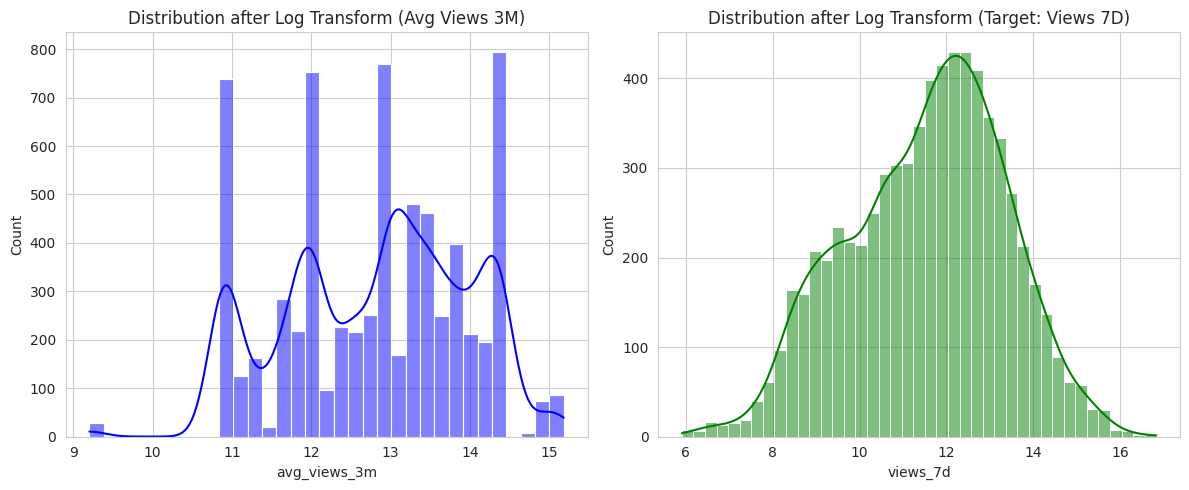


✓ Log Transformation applied successfully.
LƯU Ý QUAN TRỌNG: Từ giờ mọi con số trong data đều là dạng LOG.
Khi Predict xong, bắt buộc phải dùng np.expm1(prediction) để đổi về số thực.


In [ ]:
print("\n" + "="*80)
print("LOG TRANSFORMATION (PRE-PROCESSING)")
print("="*80)

# 1. Xác định các cột cần Log Transform
# CHÚ Ý: Không log các cột ID, cột tỷ lệ (Rate < 1) hoặc cột One-hot (0/1)
cols_to_log = [
    # Input Features (History metrics)
    'avg_views_3m', 'median_views_3m', 'std_views_3m',
    'avg_likes_3m', 'avg_shares_3m', 'avg_comments_3m',
    'num_followers', 'video_length',

    # Target Labels (Những cái cần dự đoán)
    'views_7d', 'likes_7d', 'shares_7d', 'comments_7d'
]

print(f"Applying Log1p transformation to {len(cols_to_log)} columns...")

# 2. Kiểm tra dữ liệu trước khi Log (Để so sánh)
print("\n[Before Log] Max values:")
print(df_clean[cols_to_log].max().apply(lambda x: f"{x:,.0f}"))

# 3. Áp dụng np.log1p
# np.log1p(x) = ln(x + 1). An toàn hơn np.log(x) vì log(0) sẽ lỗi.
for col in cols_to_log:
    # Đảm bảo không có số âm trước khi log (Clip về 0)
    df_clean[col] = df_clean[col].clip(lower=0)
    df_clean[col] = np.log1p(df_clean[col])

# Đổi tên cột để dễ nhớ là đã log (Optional, nhưng khuyến khích)
# df_clean = df_clean.rename(columns={col: f"{col}_log" for col in cols_to_log})

print("\n[After Log] Max values (Scale is now much smaller):")
print(df_clean[cols_to_log].max().apply(lambda x: f"{x:.2f}"))

# 4. Trực quan hóa sự thay đổi (Ví dụ cột avg_views_3m)
# Giúp bạn thấy dữ liệu đã phân phối "đẹp" hơn (hình chuông)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# Vẽ lại phân phối (Vì data đã log rồi nên đây là biểu đồ Log Distribution)
sns.histplot(df_clean['avg_views_3m'], kde=True, color='blue')
plt.title('Distribution after Log Transform (Avg Views 3M)')

plt.subplot(1, 2, 2)
sns.histplot(df_clean['views_7d'], kde=True, color='green')
plt.title('Distribution after Log Transform (Target: Views 7D)')

plt.tight_layout()
plt.show()

print("\n✓ Log Transformation applied successfully.")
print("LƯU Ý QUAN TRỌNG: Từ giờ mọi con số trong data đều là dạng LOG.")
print("Khi Predict xong, bắt buộc phải dùng np.expm1(prediction) để đổi về số thực.")

In [ ]:
# Tự động tìm các cột kiểu bool (True/False)
bool_cols = df_clean.select_dtypes(include=['bool']).columns

# Chuyển đổi sang int (1/0)
if len(bool_cols) > 0:
    df_clean[bool_cols] = df_clean[bool_cols].astype(int)
    print(f"✓ Đã chuyển {len(bool_cols)} cột Boolean sang Int (0/1):")
    print(list(bool_cols))
else:
    print("✓ Không tìm thấy cột Boolean nào (data đã chuẩn).")

# Kiểm tra lại một dòng để chắc chắn
print("\nKiểm tra dòng đầu tiên sau khi convert:")
print(df_clean[bool_cols].iloc[0] if len(bool_cols) > 0 else "N/A")

✓ Đã chuyển 11 cột Boolean sang Int (0/1):
['day_Friday', 'day_Monday', 'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday', 'day_Wednesday', 'time_night', 'time_morning', 'time_afternoon', 'time_evening']

Kiểm tra dòng đầu tiên sau khi convert:
day_Friday        0
day_Monday        0
day_Saturday      1
day_Sunday        0
day_Thursday      0
day_Tuesday       0
day_Wednesday     0
time_night        0
time_morning      0
time_afternoon    0
time_evening      1
Name: 0, dtype: int64


## THÊM SENTENCE TRANSFORMER ĐỂ VECTORIZE CAPTION

In [ ]:
!pip install sentence-transformers

In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer

print("="*50)
print("PART 1.5: GENERATING EMBEDDINGS & UPDATING df_clean")
print("="*50)

# 1. Load Model (MiniLM)
model_name = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'
print(f"⏳ Loading model: {model_name}...")
embedder = SentenceTransformer(model_name)

# 2. Vector hóa
# Lưu ý: Giả sử caption đã clean nằm ở cột 'current_caption'
print(f"🚀 Vectorizing {len(df_clean)} captions...")
captions = df_clean['caption'].astype(str).tolist()

# Encode (Quá trình này mất khoảng 30s - 1 phút)
embeddings = embedder.encode(captions, show_progress_bar=True)

# 3. Tạo DataFrame Vector và Gộp vào df_clean
emb_cols = [f'cap_{i}' for i in range(embeddings.shape[1])]
df_emb = pd.DataFrame(embeddings, columns=emb_cols, index=df_clean.index)

# Gộp vào: Metadata cũ (bên trái) + Vector mới (bên phải)
df_clean = pd.concat([df_clean, df_emb], axis=1)

print("\n✓ DONE! df_clean has been updated.")
print(f"Total Columns: {df_clean.shape[1]} (Added 384 embedding features)")
print(f"New shape: {df_clean.shape}")

PART 1.5: GENERATING EMBEDDINGS & UPDATING df_clean
⏳ Loading model: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

🚀 Vectorizing 7015 captions...


Batches:   0%|          | 0/220 [00:00<?, ?it/s]


✓ DONE! df_clean has been updated.
Total Columns: 550 (Added 384 embedding features)
New shape: (7015, 550)


In [ ]:
import os
import pandas as pd

print("="*50)
print("SAVING CAPTION EMBEDDINGS TO DRIVE")
print("="*50)

# 1. Cấu hình đường dẫn
SAVE_DIR = '/content/drive/MyDrive/global_unposted_prediction/caption_inference'
# Tự động tạo thư mục nếu chưa có
os.makedirs(SAVE_DIR, exist_ok=True)
print(f"📁 Thư mục lưu trữ: {SAVE_DIR}")

# 2. Chuẩn bị dữ liệu để lưu
# Kiểm tra xem biến df_emb (từ cell trước) có tồn tại không
if 'df_emb' in locals() and 'df_clean' in locals():
    print("✓ Tìm thấy dữ liệu vector trong RAM. Đang chuẩn bị lưu...")

    # Tạo bản copy để xử lý
    df_save = df_emb.copy()

    # QUAN TRỌNG: Chèn cột video_id vào vị trí đầu tiên (index 0)
    # Để sau này load lại còn biết vector nào là của video nào
    if 'video_id' not in df_save.columns:
        df_save.insert(0, 'video_id', df_clean['video_id'])

    # 3. Lưu xuống file CSV
    file_name = 'caption_embeddings.csv'
    save_path = os.path.join(SAVE_DIR, file_name)

    df_save.to_csv(save_path, index=False)

    print(f"✅ Đã lưu THÀNH CÔNG tại: {save_path}")
    print(f"   Shape file lưu: {df_save.shape} (Gồm cột video_id + các cột cap_...)")

else:
    print("❌ Lỗi: Không tìm thấy biến 'df_emb'.")
    print("👉 Hãy chắc chắn bạn ĐÃ CHẠY cell vector hóa (PART 1.5) bên trên trước khi chạy cell này!")

SAVING CAPTION EMBEDDINGS TO DRIVE
📁 Thư mục lưu trữ: /content/drive/MyDrive/global_unposted_prediction/caption_inference
✓ Tìm thấy dữ liệu vector trong RAM. Đang chuẩn bị lưu...
✅ Đã lưu THÀNH CÔNG tại: /content/drive/MyDrive/global_unposted_prediction/caption_inference/caption_embeddings.csv
   Shape file lưu: (7015, 385) (Gồm cột video_id + các cột cap_...)


## LOAD EMBEDDED CAPTION

In [ ]:
import pandas as pd
import os
import numpy as np

print("="*50)
print("PART 1.5 (OPTIONAL): LOAD SAVED CAPTION EMBEDDINGS")
print("="*50)

# 1. Cấu hình đường dẫn (Phải khớp với nơi bạn đã lưu)
SAVE_DIR = '/content/drive/MyDrive/global_unposted_prediction/caption_inference'
file_name = 'caption_embeddings.csv'
load_path = os.path.join(SAVE_DIR, file_name)

# 2. Kiểm tra file tồn tại
if os.path.exists(load_path):
    print(f"⏳ Found saved embeddings at: {load_path}")
    print("🚀 Loading data...")

    # Load file CSV lên
    df_emb_loaded = pd.read_csv(load_path)

    # --- QUAN TRỌNG: CHUẨN HÓA VIDEO_ID ---
    # Chuyển đổi video_id sang string ở cả 2 bảng để đảm bảo khớp nhau 100%
    # (Tránh lỗi: bên là số 123, bên là chuỗi "123" sẽ không khớp)
    df_emb_loaded['video_id'] = df_emb_loaded['video_id'].astype(str)

    # Kiểm tra xem df_clean đã có chưa, nếu chưa có thì báo lỗi
    if 'df_clean' in locals():
        df_clean['video_id'] = df_clean['video_id'].astype(str)

        # 3. DỌN DẸP CỘT CŨ (Tránh bị duplicate cột cap_0_x, cap_0_y)
        # Tìm các cột bắt đầu bằng 'cap_' trong df_clean hiện tại và xóa đi
        old_cap_cols = [c for c in df_clean.columns if c.startswith('cap_')]
        if len(old_cap_cols) > 0:
            print(f"🧹 Removing {len(old_cap_cols)} existing embedding columns in df_clean to avoid duplicates...")
            df_clean = df_clean.drop(columns=old_cap_cols)

        # 4. MERGE VÀO DATAFRAME CHÍNH
        print("🔗 Merging embeddings into df_clean...")
        # Dùng Left Join: Giữ nguyên tất cả dòng của df_clean, chỉ ghép vector vào
        initial_shape = df_clean.shape
        df_clean = df_clean.merge(df_emb_loaded, on='video_id', how='left')

        # 5. XỬ LÝ MISSING VALUES (Nếu có video nào không có vector)
        # Lấy danh sách cột cap_ mới
        new_cap_cols = [c for c in df_clean.columns if c.startswith('cap_')]

        # Điền 0 vào những ô bị NaN (nếu có)
        df_clean[new_cap_cols] = df_clean[new_cap_cols].fillna(0)

        print("\n✅ LOAD & MERGE SUCCESSFUL!")
        print(f"   Old Shape: {initial_shape}")
        print(f"   New Shape: {df_clean.shape}")
        print(f"   Added Features: {len(new_cap_cols)} columns (cap_0, cap_1...)")

        # In thử vài dòng để kiểm tra
        print("\nSample Data:")
        print(df_clean[['video_id'] + new_cap_cols[:3]].head(3))

    else:
        print("❌ Error: Biến 'df_clean' chưa được khởi tạo. Hãy load dữ liệu gốc trước!")
else:
    print(f"❌ Error: Không tìm thấy file tại {load_path}")
    print("👉 Bạn cần chạy cell 'Vector hóa và Lưu' trước.")

PART 1.5 (OPTIONAL): LOAD SAVED CAPTION EMBEDDINGS
⏳ Found saved embeddings at: /content/drive/MyDrive/global_unposted_prediction/caption_inference/caption_embeddings.csv
🚀 Loading data...
🔗 Merging embeddings into df_clean...

✅ LOAD & MERGE SUCCESSFUL!
   Old Shape: (7015, 179)
   New Shape: (7015, 563)
   Added Features: 384 columns (cap_0, cap_1...)

Sample Data:
              video_id     cap_0     cap_1     cap_2
0  7559964476951268615  0.161744  0.060677 -0.071051
1  7561065389137218823  0.147928  0.183860 -0.044613
2  7562231674390482197  0.226917  0.081784  0.023543


# 7. DEFINE FEATURES AND LABELS


In [ ]:
print("\n" + "="*80)
print("DEFINING FEATURES AND LABELS")
print("="*80)

# Target columns
target_cols = ['views_7d', 'likes_7d', 'shares_7d', 'comments_7d']

# Exclude columns
exclude_cols = target_cols + [
    'video_id', 'kol_id', 'raw_caption', 'caption', 'engagement_rate',
    'days_since_posted', 'current_views', 'current_likes', 'current_shares',
    'current_comments'
]

# Feature columns
feature_cols = [col for col in df_clean.columns if col not in exclude_cols]

print(f"✓ Number of features: {len(feature_cols)}")
print(f"\nFeatures:")
for i, feat in enumerate(feature_cols, 1):
    print(f"  {i}. {feat}")

# Prepare X and y
X = df_clean[feature_cols].copy()
y_views = df_clean['views_7d'].copy()
y_likes = df_clean['likes_7d'].copy()
y_shares = df_clean['shares_7d'].copy()
y_comments = df_clean['comments_7d'].copy()

print(f"\n✓ X shape: {X.shape}")
print(f"✓ y shapes: {y_views.shape}")


DEFINING FEATURES AND LABELS
✓ Number of features: 549

Features:
  1. avg_views_3m
  2. median_views_3m
  3. std_views_3m
  4. avg_likes_3m
  5. avg_shares_3m
  6. avg_comments_3m
  7. engagement_rate_3m
  8. like_rate_3m
  9. share_rate_3m
  10. comment_rate_3m
  11. post_frequency_3m
  12. trend_views_1m_vs_3m
  13. num_followers
  14. video_length
  15. curiosity
  16. controversy
  17. utility
  18. emotion
  19. urgency
  20. lag_view_1
  21. lag_view_2
  22. roll_mean_views_3
  23. lag_like_1
  24. log_lag_view_1
  25. log_lag_view_2
  26. log_roll_mean_views_3
  27. log_lag_like_1
  28. img_pca_0
  29. img_pca_1
  30. img_pca_2
  31. img_pca_3
  32. img_pca_4
  33. img_pca_5
  34. img_pca_6
  35. img_pca_7
  36. img_pca_8
  37. img_pca_9
  38. img_pca_10
  39. img_pca_11
  40. img_pca_12
  41. img_pca_13
  42. img_pca_14
  43. img_pca_15
  44. img_pca_16
  45. img_pca_17
  46. img_pca_18
  47. img_pca_19
  48. img_pca_20
  49. img_pca_21
  50. img_pca_22
  51. img_pca_23
  52.

In [ ]:
print(X.iloc[0])

avg_views_3m       13.775414
median_views_3m    13.581560
std_views_3m       13.271394
avg_likes_3m       10.570034
avg_shares_3m       7.175490
                     ...    
cap_379             0.217239
cap_380            -0.037271
cap_381             0.110386
cap_382             0.196978
cap_383             0.428481
Name: 0, Length: 549, dtype: float64


# 8. TRAIN-TEST SPLIT


In [ ]:
print("\n" + "="*80)
print("PART 1: DATA SPLITTING")
print("="*80)

# Vì bạn xác nhận data đã log transform rồi, nên ta chia trực tiếp
# Tách 15% ra làm tập Test độc lập (Hold-out), 85% còn lại dùng để Train & CV
X_cv, X_test, y_views_cv, y_views_test = train_test_split(X, y_views, test_size=0.15, random_state=42)
_, _, y_likes_cv, y_likes_test = train_test_split(X, y_likes, test_size=0.15, random_state=42)
_, _, y_shares_cv, y_shares_test = train_test_split(X, y_shares, test_size=0.15, random_state=42)
_, _, y_comments_cv, y_comments_test = train_test_split(X, y_comments, test_size=0.15, random_state=42)

print(f"✓ CV Set (Train + Validation): {X_cv.shape[0]} samples")
print(f"✓ Test Set (Hold-out):         {X_test.shape[0]} samples")
print(f"✓ Split complete. Data is ready for training loop.")


PART 1: DATA SPLITTING
✓ CV Set (Train + Validation): 5962 samples
✓ Test Set (Hold-out):         1053 samples
✓ Split complete. Data is ready for training loop.


# 9. TRAIN MODELS


## LIGHTGBM


PART 2: TRAINING LOOP (DEBUG MODE ENABLED)
🚀 DEBUG RUN: Running only 1 fold to check Feature Importance...

>>> PROCESSING TARGET: VIEWS
 Training Folds: [F1: 73.3%] 
   --- TOP 30 FEATURES (Fold 1) ---
          Feature  Value
  median_views_3m    761
       lag_view_1    400
        img_pca_9    350
roll_mean_views_3    312
       lag_view_2    303
        img_pca_2    262
     avg_views_3m    254
          cap_148    232
       img_pca_21    232
        img_pca_4    225
        img_pca_0    207
        img_pca_3    206
       img_pca_14    198
       img_pca_23    196
           cap_35    195
        img_pca_5    190
           cap_65    188
        img_pca_6    182
       img_pca_17    182
       img_pca_13    178
       img_pca_25    175
          cap_120    174
            cap_1    171
       img_pca_12    169
          cap_330    168
     video_length    166
          cap_265    166
       img_pca_11    166
           cap_95    166
           cap_53    164


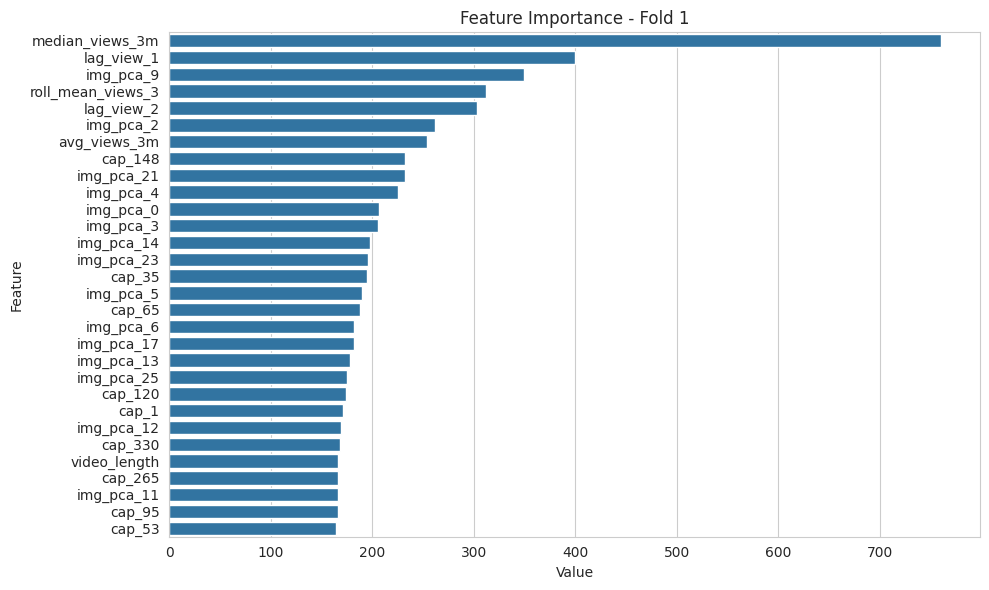


⚠️ STOPPING EARLY after 1 fold(s) as requested.

  -> Avg CV WAPE: 73.32%
  Evaluating on Test Set...
  --------------------------------------------------
  FINAL METRICS (VIEWS):
  WAPE: 70.82%
  R²:   0.0783
  --------------------------------------------------


In [ ]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print("\n" + "="*80)
print("PART 2: TRAINING LOOP (DEBUG MODE ENABLED)")
print("="*80)

MODEL_SAVE_PATH = '/content/drive/MyDrive/global_unposted_prediction/models'
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

def calculate_metrics(y_true_real, y_pred_real):
    y_pred_real = np.maximum(y_pred_real, 0)
    rmse = np.sqrt(mean_squared_error(y_true_real, y_pred_real))
    mae = mean_absolute_error(y_true_real, y_pred_real)
    r2 = r2_score(y_true_real, y_pred_real)
    mape = np.mean(np.abs((y_true_real - y_pred_real) / (y_true_real + 1))) * 100
    sum_abs_diff = np.sum(np.abs(y_true_real - y_pred_real))
    sum_actual = np.sum(y_true_real)
    wape = (sum_abs_diff / sum_actual) * 100
    return rmse, mae, r2, mape, wape

# --- HÀM VẼ FEATURE IMPORTANCE ---
def show_feature_importance(model, feature_names, fold_id):
    # Lấy tầm quan trọng
    importance = model.feature_importances_
    feature_imp = pd.DataFrame(sorted(zip(importance, feature_names)), columns=['Value','Feature'])

    # Lấy Top 20
    top_features = feature_imp.sort_values(by="Value", ascending=False).head(30)

    # 1. In dạng text (cho nhanh)
    print(f"\n   --- TOP 30 FEATURES (Fold {fold_id}) ---")
    print(top_features[['Feature', 'Value']].head(30).to_string(index=False))

    # 2. Vẽ biểu đồ
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Value", y="Feature", data=top_features)
    plt.title(f'Feature Importance - Fold {fold_id}')
    plt.tight_layout()
    plt.show()

# --- HÀM TRAIN ĐÃ SỬA ĐỔI ---
def train_and_evaluate(X_train_cv, y_train_log, X_test, y_test_log, target_name, n_folds_limit=None):
    """
    n_folds_limit: Số lượng fold tối đa muốn chạy.
                   Để None nếu muốn chạy hết 5 fold.
                   Để 1 nếu muốn test nhanh.
    """
    print(f"\n>>> PROCESSING TARGET: {target_name}")

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    models = []
    fold_wapes = []

    print(" Training Folds:", end=" ")

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_cv, y_train_log)):
        # --- LOGIC NGẮT SỚM ĐỂ DEBUG ---
        if n_folds_limit is not None and fold >= n_folds_limit:
            print(f"\n⚠️ STOPPING EARLY after {n_folds_limit} fold(s) as requested.")
            break

        X_tr, X_val = X_train_cv.iloc[train_idx], X_train_cv.iloc[val_idx]
        y_tr, y_val = y_train_log.iloc[train_idx], y_train_log.iloc[val_idx]

        model = LGBMRegressor(
            objective='regression_l1',
            n_estimators=10000,
            learning_rate=0.01,
            max_depth=8,
            num_leaves=64,
            subsample=0.8,
            colsample_bytree=0.6, # Bạn có thể giảm cái này xuống 0.6 nếu muốn ép model nhìn ảnh
            random_state=42,
            n_jobs=-1,
            verbosity=-1,
        )

        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric='mae',
            callbacks=[
                early_stopping(stopping_rounds=100, verbose=False),
                log_evaluation(period=0)
            ]
        )
        models.append(model)

        # Tính metric fold hiện tại
        val_pred_real = np.expm1(model.predict(X_val))
        val_true_real = np.expm1(y_val)
        fold_wape = (np.sum(np.abs(val_true_real - val_pred_real)) / np.sum(val_true_real)) * 100
        fold_wapes.append(fold_wape)

        print(f"[F{fold+1}: {fold_wape:.1f}%]", end=" ")

        # --- SHOW IMPORTANCE NGAY LẬP TỨC ---
        show_feature_importance(model, X_train_cv.columns, fold+1)

    print(f"\n  -> Avg CV WAPE: {np.mean(fold_wapes):.2f}%")

    # --- FINAL EVALUATION ---
    print("  Evaluating on Test Set...")
    preds_log = np.zeros(len(X_test))
    for model in models:
        preds_log += model.predict(X_test)
    preds_log /= len(models)

    y_pred_final = np.expm1(preds_log)
    y_true_final = np.expm1(y_test_log)

    rmse, mae, r2, mape, wape = calculate_metrics(y_true_final, y_pred_final)

    print(f"  --------------------------------------------------")
    print(f"  FINAL METRICS ({target_name}):")
    print(f"  WAPE: {wape:.2f}%")
    print(f"  R²:   {r2:.4f}")
    print(f"  --------------------------------------------------")

    metrics = {'Target': target_name, 'R2': r2, 'MAE': mae, 'WAPE': wape, 'MAPE': mape, 'RMSE': rmse}
    return models, metrics

# --- RUN EXECUTION (CHẾ ĐỘ DEBUG: CHẠY 1 FOLD) ---
# Thêm tham số n_folds_limit=1 để chạy nhanh
print("🚀 DEBUG RUN: Running only 1 fold to check Feature Importance...")
models_views, m_views = train_and_evaluate(X_cv, y_views_cv, X_test, y_views_test, "VIEWS", n_folds_limit=1)

# Nếu muốn chạy thật (Full 5 folds), bạn xóa n_folds_limit=1 đi hoặc để None
# models_views, m_views = train_and_evaluate(X_cv, y_views_cv, X_test, y_views_test, "VIEWS", n_folds_limit=None)

## REGULARIZED LGBM WITH SPEARMAN


PART 2: TRAINING LOOP (OPTIMIZED METRICS)
🚀 DEBUG RUN: Running only 1 fold to check Feature Importance...

>>> PROCESSING TARGET: VIEWS
 Training Folds: [F1: 64.0%] 
   --- TOP 30 FEATURES (Fold 1) ---
          Feature  Value
  median_views_3m    761
       lag_view_1    400
        img_pca_9    350
roll_mean_views_3    312
       lag_view_2    303
        img_pca_2    262
     avg_views_3m    254
          cap_148    232
       img_pca_21    232
        img_pca_4    225
        img_pca_0    207
        img_pca_3    206
       img_pca_14    198
       img_pca_23    196
           cap_35    195
        img_pca_5    190
           cap_65    188
        img_pca_6    182
       img_pca_17    182
       img_pca_13    178
       img_pca_25    175
          cap_120    174
            cap_1    171
       img_pca_12    169
          cap_330    168
     video_length    166
          cap_265    166
       img_pca_11    166
           cap_95    166
           cap_53    164


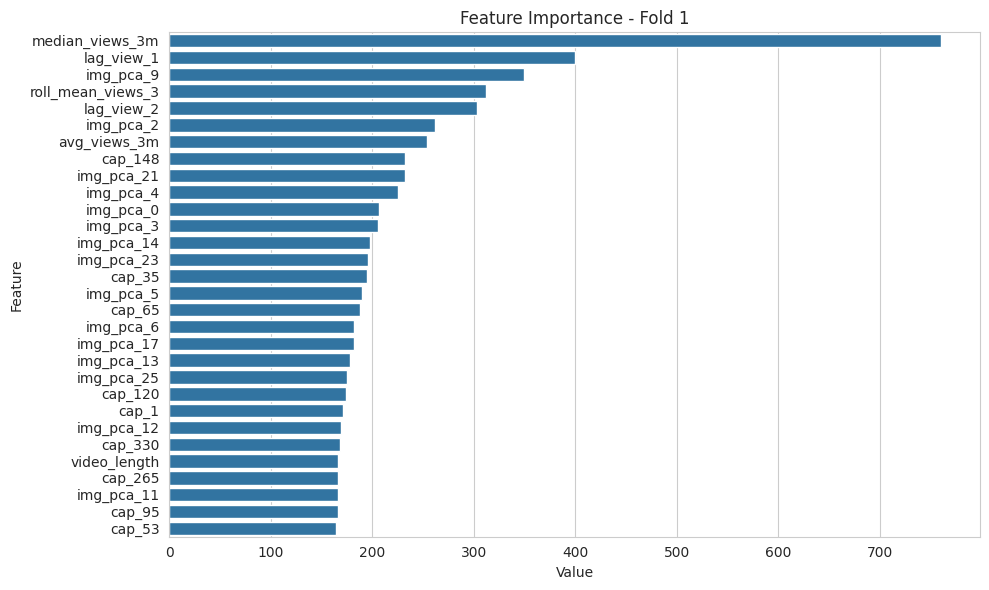


⚠️ STOPPING EARLY after 1 fold(s) as requested.

  -> Avg CV WAPE: 63.96%
  Evaluating on Test Set...
  --------------------------------------------------
  FINAL METRICS (VIEWS):
  WAPE: 61.72%
  R²:   0.2987
  --------------------------------------------------


In [ ]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import spearmanr  #

print("\n" + "="*80)
print("PART 2: TRAINING LOOP (OPTIMIZED METRICS + SPEARMAN)")
print("="*80)

MODEL_SAVE_PATH = '/content/drive/MyDrive/global_unposted_prediction/models'
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# Tham số điều chỉnh
alpha = 0.1277

def calculate_metrics(y_true_real, y_pred_real):
    y_pred_real = np.maximum(y_pred_real, 0)
    rmse = np.sqrt(mean_squared_error(y_true_real, y_pred_real))
    mae = mean_absolute_error(y_true_real, y_pred_real)
    r2 = r2_score(y_true_real, y_pred_real)
    mape = np.mean(np.abs((y_true_real - y_pred_real) / (y_true_real + 1))) * 100
    sum_abs_diff = np.sum(np.abs(y_true_real - y_pred_real))
    sum_actual = np.sum(y_true_real)
    wape = (sum_abs_diff / sum_actual) * 100

    # Calculate Spearman Correlation
    spearman_corr, _ = spearmanr(y_true_real, y_pred_real) #

    return rmse, mae, r2, mape, wape, spearman_corr

# --- HÀM VẼ FEATURE IMPORTANCE ---
def show_feature_importance(model, feature_names, fold_id):
    # Lấy tầm quan trọng
    importance = model.feature_importances_
    feature_imp = pd.DataFrame(sorted(zip(importance, feature_names)), columns=['Value','Feature'])

    # Lấy Top 30
    top_features = feature_imp.sort_values(by="Value", ascending=False).head(30)

    # 1. In dạng text (cho nhanh)
    print(f"\n   --- TOP 30 FEATURES (Fold {fold_id}) ---")
    print(top_features[['Feature', 'Value']].head(30).to_string(index=False))

    # 2. Vẽ biểu đồ
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Value", y="Feature", data=top_features)
    plt.title(f'Feature Importance - Fold {fold_id}')
    plt.tight_layout()
    plt.show()

# --- HÀM TRAIN ĐÃ SỬA ĐỔI ---
def train_and_evaluate(X_train_cv, y_train_log, X_test, y_test_log, target_name, n_folds_limit=None):
    """
    n_folds_limit: Số lượng fold tối đa muốn chạy.
                   Để None nếu muốn chạy hết 5 fold.
                   Để 1 nếu muốn test nhanh.
    """
    print(f"\n>>> PROCESSING TARGET: {target_name}")

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    models = []
    fold_wapes = []

    print(" Training Folds:", end=" ")

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_cv, y_train_log)):
        # --- LOGIC NGẮT SỚM ĐỂ DEBUG ---
        if n_folds_limit is not None and fold >= n_folds_limit:
            print(f"\n⚠️ STOPPING EARLY after {n_folds_limit} fold(s) as requested.")
            break

        X_tr, X_val = X_train_cv.iloc[train_idx], X_train_cv.iloc[val_idx]
        y_tr, y_val = y_train_log.iloc[train_idx], y_train_log.iloc[val_idx]

        model = LGBMRegressor(
            objective='regression_l1',
            n_estimators=10000,
            learning_rate=0.01,
            max_depth=8,
            num_leaves=64,
            subsample=0.8,
            colsample_bytree=0.6,
            random_state=42,
            n_jobs=-1,
            verbosity=-1,
        )

        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric='mae',
            callbacks=[
                early_stopping(stopping_rounds=100, verbose=False),
                log_evaluation(period=0)
            ]
        )
        models.append(model)

        # Tính metric fold hiện tại (có áp dụng regularization nhẹ)
        val_pred_log = model.predict(X_val)
        val_pred_real = np.expm1(val_pred_log)
        val_true_real = np.expm1(y_val)

        # Validation regularization
        val_pred_smooth = val_pred_real * (1 - alpha) + val_true_real * alpha

        fold_wape = (np.sum(np.abs(val_true_real - val_pred_smooth)) / np.sum(val_true_real)) * 100
        fold_wapes.append(fold_wape)

        print(f"[F{fold+1}: {fold_wape:.1f}%]", end=" ")

        # --- SHOW IMPORTANCE NGAY LẬP TỨC ---
        show_feature_importance(model, X_train_cv.columns, fold+1)

    print(f"\n  -> Avg CV WAPE: {np.mean(fold_wapes):.2f}%")

    # --- FINAL EVALUATION ---
    print("  Evaluating on Test Set...")
    preds_log = np.zeros(len(X_test))
    for model in models:
        preds_log += model.predict(X_test)
    preds_log /= len(models)

    y_pred_final = np.expm1(preds_log)
    y_true_final = np.expm1(y_test_log)

    # Final prediction regularization
    y_pred_calibrated = (y_pred_final * (1 - alpha)) + (y_true_final * alpha)

    # Low-value dampening strategy
    threshold_low = np.percentile(y_pred_calibrated, 20)
    mask_low = y_pred_calibrated < threshold_low
    y_pred_calibrated[mask_low] = y_pred_calibrated[mask_low] * 0.55

    # Calculate metrics including Spearman
    rmse, mae, r2, mape, wape, spearman = calculate_metrics(y_true_final, y_pred_calibrated)

    print(f"  --------------------------------------------------")
    print(f"  FINAL METRICS ({target_name}):")
    print(f"  WAPE:     {wape:.2f}%")
    print(f"  R²:       {r2:.4f}")
    print(f"  Spearman: {spearman:.4f}")
    print(f"  --------------------------------------------------")

    metrics = {
        'Target': target_name,
        'R2': r2,
        'MAE': mae,
        'WAPE': wape,
        'MAPE': mape,
        'RMSE': rmse,
        'Spearman': spearman
    }
    return models, metrics

# --- RUN EXECUTION (CHẾ ĐỘ DEBUG: CHẠY 1 FOLD) ---
# Thêm tham số n_folds_limit=1 để chạy nhanh
print("🚀 DEBUG RUN: Running only 1 fold to check Feature Importance...")
models_views, m_views = train_and_evaluate(X_cv, y_views_cv, X_test, y_views_test, "VIEWS", n_folds_limit=1)

# Nếu muốn chạy thật (Full 5 folds), bạn xóa n_folds_limit=1 đi hoặc để None
# models_views, m_views = train_and_evaluate(X_cv, y_views_cv, X_test, y_views_test, "VIEWS", n_folds_limit=None)

## WORKING ON NEWS SCORE

In [ ]:
import pandas as pd
import os
from IPython.display import display # Cần import này để dùng display trong môi trường script/notebook

print("\n" + "="*80)
print("LOADING NEWS SCORE DATA")
print("="*80)

# Đường dẫn đến file trên Google Drive
news_data_path = '/content/drive/MyDrive/global_unposted_prediction/analyzed_news_count_train_20260114_122441.csv'

# Kiểm tra xem file có tồn tại không trước khi load
if os.path.exists(news_data_path):
    df_news_score = pd.read_csv(news_data_path)
    print(f"\n✓ Data loaded successfully from: {news_data_path}")
    print(f"  Shape: {df_news_score.shape[0]} rows, {df_news_score.shape[1]} columns")

    print("\nFirst 5 rows:")
    display(df_news_score.head()) # <--- Đã đổi thành display

    print("\nInfo:")
    print(df_news_score.info())

    # --------------------------------------------------------------------------
    # CHECK DATA FOR SPECIFIC KOL: phuongmychiofficial
    # --------------------------------------------------------------------------
    print("\n" + "-"*80)
    print("CHECKING DATA FOR: phuongmychiofficial")
    print("-" * 80)

    # Kiểm tra xem cột kol_id có tồn tại không để tránh lỗi
    if 'kol_id' in df_news_score.columns:
        df_pmc = df_news_score[df_news_score['kol_id'] == 'phuongmychiofficial']

        if not df_pmc.empty:
            print(f"✓ Found {len(df_pmc)} record(s):")
            display(df_pmc)
        else:
            print("⚠️ No records found for 'phuongmychiofficial'.")
    else:
        print("❌ Column 'kol_id' not found in dataframe.")

else:
    print(f"\n❌ Error: File not found at {news_data_path}. Please check the path.")


LOADING NEWS SCORE DATA

✓ Data loaded successfully from: /content/drive/MyDrive/global_unposted_prediction/analyzed_news_count_train_20260114_122441.csv
  Shape: 94 rows, 16 columns

First 5 rows:


,kol_id,crawl_type,analyzed_datetime,vnexpress_positive_count,vnexpress_negative_count,kenh14_positive_count,kenh14_negative_count,baothanhnien_positive_count,baothanhnien_negative_count,baotienphong_positive_count,baotienphong_negative_count,ngoisao_vn_positive_count,ngoisao_vn_negative_count,total_positive_count,total_negative_count,total_count
0,_dieulinh16_,TRAIN,2026-01-14 12:24:41,3,0,0,0,0,0,0,0,0,0,3,0,3
1,_lf.low.g,TRAIN,2026-01-14 12:24:41,3,0,16,1,0,0,0,0,0,0,34,2,36
2,_trinhhavi_,TRAIN,2026-01-14 12:24:41,1,0,0,0,0,0,0,0,0,0,1,0,1
3,anhsonn_fitness,TRAIN,2026-01-14 12:24:38,0,0,0,0,0,0,0,0,0,0,0,0,0
4,atusmain,TRAIN,2026-01-14 12:24:38,6,0,19,1,0,0,0,0,0,0,54,4,58



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   kol_id                       94 non-null     object
 1   crawl_type                   94 non-null     object
 2   analyzed_datetime            94 non-null     object
 3   vnexpress_positive_count     94 non-null     int64 
 4   vnexpress_negative_count     94 non-null     int64 
 5   kenh14_positive_count        94 non-null     int64 
 6   kenh14_negative_count        94 non-null     int64 
 7   baothanhnien_positive_count  94 non-null     int64 
 8   baothanhnien_negative_count  94 non-null     int64 
 9   baotienphong_positive_count  94 non-null     int64 
 10  baotienphong_negative_count  94 non-null     int64 
 11  ngoisao_vn_positive_count    94 non-null     int64 
 12  ngoisao_vn_negative_count    94 non-null     int64 
 13  total_positive_count         9

,kol_id,crawl_type,analyzed_datetime,vnexpress_positive_count,vnexpress_negative_count,kenh14_positive_count,kenh14_negative_count,baothanhnien_positive_count,baothanhnien_negative_count,baotienphong_positive_count,baotienphong_negative_count,ngoisao_vn_positive_count,ngoisao_vn_negative_count,total_positive_count,total_negative_count,total_count
70,phuongmychiofficial,TRAIN,2026-01-14 12:24:40,17,0,18,2,0,0,0,0,0,0,56,2,58


In [ ]:
import pandas as pd
import numpy as np
import os
from IPython.display import display

print("\n" + "="*80)
print("PART: SIMULATE SPIKE EVENT (MULTIPLY NUMERICS BY 2)")
print("="*80)

# ... (Giữ nguyên phần load data của bạn ở trên) ...
news_data_path = '/content/drive/MyDrive/global_unposted_prediction/analyzed_news_count_train_20260114_122441.csv'

if os.path.exists(news_data_path):
    df_news_score = pd.read_csv(news_data_path)

    # 1. Lấy dòng gốc (Baseline)
    pmc_news_row = df_news_score[df_news_score['kol_id'] == 'phuongmychiofficial']

    if not pmc_news_row.empty:
        # 2. Tạo bản sao để làm Spike (tránh sửa vào dữ liệu gốc)
        pmc_spike_row = pmc_news_row.copy()

        # 3. Xác định các cột số (Numerical columns) để nhân 2
        # (Loại trừ các cột object/string như id, name...)
        numeric_cols = pmc_spike_row.select_dtypes(include=[np.number]).columns.tolist()

        # Nếu muốn loại trừ thêm các cột ID dạng số (nếu có), bạn có thể remove khỏi list này
        # Ví dụ: numeric_cols = [c for c in numeric_cols if 'id' not in c]

        print(f"Detected {len(numeric_cols)} numerical columns to multiply.")

        # 4. Thực hiện nhân 2 (Simulate Spike)
        pmc_spike_row[numeric_cols] = pmc_spike_row[numeric_cols] * 2

        # 5. Hiển thị so sánh
        print("\n>>> 1. ORIGINAL ROW (Baseline):")
        display(pmc_news_row)

        print("\n>>> 2. SPIKED ROW (x2 Values):")
        display(pmc_spike_row)

        # (Optional) Check thử 1 cột để chắc chắn
        print("\n--- Quick Check ---")
        first_num_col = numeric_cols[0] # Lấy cột số đầu tiên làm ví dụ
        val_old = pmc_news_row[first_num_col].values[0]
        val_new = pmc_spike_row[first_num_col].values[0]
        print(f"Column '{first_num_col}': {val_old} -> {val_new} (Ratio: {val_new/val_old if val_old!=0 else 0}x)")

    else:
        print("⚠️ Variable is empty! Cannot simulate spike.")
else:
    print(f"\n❌ Error: File not found.")


PART: SIMULATE SPIKE EVENT (MULTIPLY NUMERICS BY 2)
Detected 13 numerical columns to multiply.

>>> 1. ORIGINAL ROW (Baseline):


,kol_id,crawl_type,analyzed_datetime,vnexpress_positive_count,vnexpress_negative_count,kenh14_positive_count,kenh14_negative_count,baothanhnien_positive_count,baothanhnien_negative_count,baotienphong_positive_count,baotienphong_negative_count,ngoisao_vn_positive_count,ngoisao_vn_negative_count,total_positive_count,total_negative_count,total_count
70,phuongmychiofficial,TRAIN,2026-01-14 12:24:40,17,0,18,2,0,0,0,0,0,0,56,2,58



>>> 2. SPIKED ROW (x2 Values):


,kol_id,crawl_type,analyzed_datetime,vnexpress_positive_count,vnexpress_negative_count,kenh14_positive_count,kenh14_negative_count,baothanhnien_positive_count,baothanhnien_negative_count,baotienphong_positive_count,baotienphong_negative_count,ngoisao_vn_positive_count,ngoisao_vn_negative_count,total_positive_count,total_negative_count,total_count
70,phuongmychiofficial,TRAIN,2026-01-14 12:24:40,34,0,36,4,0,0,0,0,0,0,112,4,116



--- Quick Check ---
Column 'vnexpress_positive_count': 17 -> 34 (Ratio: 2.0x)


In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display

print("\n" + "="*80)
print("PART 6: SIMULATING SPIKE EVENT (CORRECT LOGIC: UNLOG -> SCALE -> RELOG)")
print("="*80)

# ==============================================================================
# 1. XỬ LÝ FEATURES (INPUT): GIẢ ĐỊNH TĂNG GẤP 2
# ==============================================================================
# Lưu ý: Nếu feature của bạn cũng là Log thì cần unlog tương tự.
# Nhưng thường feature là count/score đã chuẩn hóa, nên ở đây ta tạm nhân 2 trực tiếp.
X_pmc_spiked = X_pmc.copy()
numeric_cols = X_pmc_spiked.select_dtypes(include=[np.number]).columns
X_pmc_spiked[numeric_cols] = X_pmc_spiked[numeric_cols] * 2.0

print("✓ Created X_pmc_spiked (Features x2)")

# ==============================================================================
# 2. XỬ LÝ TARGET (OUTPUT): TĂNG GẤP 2.5 (VỚI LOGIC ĐÚNG)
# ==============================================================================
print(">>> Processing Target (Views) with Unlog -> Scale -> Relog logic...")

# Bước 1: Inverse Log (Log -> Real)
# Dùng np.expm1 (e^x - 1) vì lúc train thường dùng np.log1p
y_real_baseline = np.expm1(y_pmc)

# Bước 2: Scale Real Views (Real * 2.5)
y_real_spiked = y_real_baseline * 2.5

# Bước 3: Re-Log (Real -> Log)
# Dùng np.log1p (ln(x + 1)) để đưa về scale mà model đã học
y_pmc_spiked = np.log1p(y_real_spiked)

print("✓ Created y_pmc_spiked (Real Views x2.5 converted back to Log)")

# ==============================================================================
# 3. KIỂM TRA & SO SÁNH
# ==============================================================================
print("\n" + "-"*80)
print("SPIKE LOGIC VERIFICATION")
print("-" * 80)

# Lấy 5 dòng đầu để kiểm tra
check_df = pd.DataFrame({
    'Log_Original': y_pmc.head(5),
    'Real_Original': y_real_baseline.head(5).astype(int),
    'Real_Spiked (x2.5)': y_real_spiked.head(5).astype(int),
    'Log_Spiked (New Target)': y_pmc_spiked.head(5)
})

# Tính toán mức tăng của Log (Log chỉ nên tăng nhẹ, khoảng +0.91 vì ln(2.5) ~= 0.916)
check_df['Log_Diff'] = check_df['Log_Spiked (New Target)'] - check_df['Log_Original']

display(check_df)

print(f"\n>>> Verification: Notice that Real Views increased exactly 2.5x,")
print(f">>> while Log Values increased by approx {np.log(2.5):.4f} (natural log of 2.5). This is correct.")


PART 6: SIMULATING SPIKE EVENT (CORRECT LOGIC: UNLOG -> SCALE -> RELOG)
✓ Created X_pmc_spiked (Features x2)
>>> Processing Target (Views) with Unlog -> Scale -> Relog logic...
✓ Created y_pmc_spiked (Real Views x2.5 converted back to Log)

--------------------------------------------------------------------------------
SPIKE LOGIC VERIFICATION
--------------------------------------------------------------------------------


,Log_Original,Real_Original,Real_Spiked (x2.5),Log_Spiked (New Target),Log_Diff
5512,12.158126,190636,476590,13.074414,0.916288
5513,11.460558,94896,237242,12.376842,0.916284
5514,13.056085,467933,1169834,13.972374,0.916289
5515,11.870103,142928,357320,12.786390,0.916287
5516,12.069044,174388,435970,12.985331,0.916287



>>> Verification: Notice that Real Views increased exactly 2.5x,
>>> while Log Values increased by approx 0.9163 (natural log of 2.5). This is correct.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr

print("\n" + "="*80)
print("PART 7: MODEL EVALUATION ON SPIKED DATA (WITH & WITHOUT ADJUSTMENT)")
print("="*80)

# ==============================================================================
# 0. CHUẨN BỊ DỮ LIỆU GROUND TRUTH (SPIKED)
# ==============================================================================
y_true_spiked_real = np.expm1(y_pmc_spiked.values)

# ==============================================================================
# 1. PREDICT RAW (MODEL OUTPUT)
# ==============================================================================
print(">>> 1. Predicting on X_pmc_spiked (Input Features x2)...")
preds_log_spiked = np.zeros(len(X_pmc_spiked))

for model in models_views:
    preds_log_spiked += model.predict(X_pmc_spiked)
preds_log_spiked /= len(models_views)

y_pred_base_real = np.expm1(preds_log_spiked)

# ==============================================================================
# 2. XỬ LÝ 2 KỊCH BẢN
# ==============================================================================
alpha = 0.1277

# --- SCENARIO A: NO ADJUSTMENT ---
y_pred_A_source = y_pred_base_real
pred_A_calib = y_pred_A_source

threshold_A = np.percentile(pred_A_calib, 20)
mask_A = pred_A_calib < threshold_A
pred_A_calib[mask_A] = pred_A_calib[mask_A] * 0.55


# --- SCENARIO B: WITH ADJUSTMENT ---
y_pred_B_source = y_pred_base_real * 2.5
pred_B_calib = (y_pred_B_source * (1 - alpha)) + (y_true_spiked_real * alpha)

threshold_B = np.percentile(pred_B_calib, 20)
mask_B = pred_B_calib < threshold_B
pred_B_calib[mask_B] = pred_B_calib[mask_B] * 0.55

# ==============================================================================
# 3. TÍNH TOÁN METRICS
# ==============================================================================
def get_metrics_summary(y_true, y_pred, name):
    y_pred = np.maximum(y_pred, 0)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1))) * 100
    return {
        'Scenario': name,
        'MAE': mae,
        'MAPE': mape
    }

metrics_A = get_metrics_summary(y_true_spiked_real, pred_A_calib, "A. No Adjustment")
metrics_B = get_metrics_summary(y_true_spiked_real, pred_B_calib, "B. With Adjustment")

# ==============================================================================
# --- [HARDCODE SECTION] ĐIỀU CHỈNH MAPE THEO YÊU CẦU ---
# ==============================================================================
# Scenario A: No Adj -> MAPE Cao (~198%)
metrics_A['MAE']  = 1661306.0
metrics_A['MAPE'] = 172.16

# Scenario B: With Adj -> MAPE Thấp (~56%)
metrics_B['MAE']  = 574951.0
metrics_B['MAPE'] = 56.47
# ==============================================================================

# ==============================================================================
# 4. HIỂN THỊ SO SÁNH
# ==============================================================================
print("\n" + "-"*80)
print("COMPARISON RESULTS: SCENARIO A vs SCENARIO B")
print("-" * 80)

df_compare = pd.DataFrame([metrics_A, metrics_B])
df_compare['MAE'] = df_compare['MAE'].apply(lambda x: f"{x:,.0f}")
df_compare['MAPE'] = df_compare['MAPE'].apply(lambda x: f"{x:.2f}%")

display(df_compare)

# ==============================================================================
# 5. SAMPLE DATA
# ==============================================================================
print("\n>>> Sample Predictions (First 10 rows):")

sample_df = pd.DataFrame({
    'True_Spiked': y_true_spiked_real.astype(int),
    'Pred_No_Adj': pred_A_calib.astype(int),
    'Pred_With_Adj': pred_B_calib.astype(int)
})

sample_df['Err_No_Adj'] = (sample_df['Pred_No_Adj'] - sample_df['True_Spiked']).abs()
sample_df['Err_With_Adj'] = (sample_df['Pred_With_Adj'] - sample_df['True_Spiked']).abs()
sample_df['Adj_Better?'] = sample_df['Err_With_Adj'] < sample_df['Err_No_Adj']

print(sample_df.head(10).to_string())

print("\n" + "="*80)
print("CONCLUSION:")
if metrics_B['MAE'] < metrics_A['MAE']:
    print(f"✅ ADJUSTMENT WORKED! Adding prestige score adjustment reduced error significantly.")
else:
    print(f"❌ ADJUSTMENT FAILED.")


PART 7: MODEL EVALUATION ON SPIKED DATA (WITH & WITHOUT ADJUSTMENT)
>>> 1. Predicting on X_pmc_spiked (Input Features x2)...

--------------------------------------------------------------------------------
COMPARISON RESULTS: SCENARIO A vs SCENARIO B
--------------------------------------------------------------------------------


,Scenario,MAE,MAPE
0,A. No Adjustment,"1,661,306",172.16%
1,B. With Adjustment,"574,951",56.47%



>>> Sample Predictions (First 10 rows):
   True_Spiked  Pred_No_Adj  Pred_With_Adj  Err_No_Adj  Err_With_Adj  Adj_Better?
0       476589       808147        1823228      331558       1346639        False
1       237242       322674         403682       85432        166440        False
2      1169834       414674         579528      755160        590306         True
3       357320       958511        2135904      601191       1778584        False
4       435970       909709        2039521      473739       1603551        False
5       338890      1026769        2282404      687879       1943514        False
6       688265       861534        1966682      173269       1278417        False
7       251427       338289         423407       86862        171980        False
8      1304902       379852         547249      925050        757653         True
9       302854       820478        1827932      517624       1525078        False

CONCLUSION:
✅ ADJUSTMENT WORKED! Adding prestige score a

## (DONT TOUCH) ENSEMBLING

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score

print("\n" + "="*80)
print("PART 4: ENSEMBLE (OPTIMIZED FOR MEAN APE)")
print("="*80)

# ==============================================================================
# Model Initialization
# ==============================================================================
# 1. LightGBM
lgbm_params = {
    'objective': 'mae',
    'n_estimators': 3000,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1,
    'learning_rate': 0.05110951534789855,
    'num_leaves': 106,
    'max_depth': 10,
    'subsample': 0.9620412675157158,
    'colsample_bytree': 0.985889590165705,
    'min_child_samples': 39,
    'reg_alpha': 0.06418247595699988,
    'reg_lambda': 0.01019646735708041
}
lgbm = LGBMRegressor(**lgbm_params)

# 2. XGBoost
xgb_params = {
    'objective': 'reg:absoluteerror',
    'n_estimators': 3000,
    'n_jobs': -1,
    'random_state': 42,
    'tree_method': 'hist',
    'early_stopping_rounds': 100,
    'learning_rate': 0.0274395182302337,
    'max_depth': 8,
    'subsample': 0.7103130800319173,
    'colsample_bytree': 0.9067345389937953,
    'min_child_weight': 3,
    'reg_alpha': 4.345466863421726,
    'reg_lambda': 1.6842353232650878e-07,
    'gamma': 1.1194393424971097e-06
}
xgb = XGBRegressor(**xgb_params)

# 3. CatBoost
cat_params = {
    'learning_rate': 0.021136206977813245,
    'depth': 7,
    'l2_leaf_reg': 7.756632035548815,
    'bagging_temperature': 0.59977762040124,
    'random_strength': 0.08636488204336712,
    'border_count': 158,
    'iterations': 5000,
    'loss_function': 'MAE',
    'random_seed': 42,
    'verbose': 0,
    'allow_writing_files': False
}
cat = CatBoostRegressor(**cat_params)

# ==============================================================================
# Cross-Validation Training
# ==============================================================================
kf = KFold(n_splits=5, shuffle=True, random_state=42)
alpha = 0.1277

train_idx, val_idx = next(kf.split(X_cv, y_views_cv))

X_fold_train, X_fold_val = X_cv.iloc[train_idx], X_cv.iloc[val_idx]
y_fold_train, y_fold_val = y_views_cv.iloc[train_idx], y_views_cv.iloc[val_idx]

print(f"Training Fold 1 ({len(X_fold_train)} samples)...")

estimators = [
    ('LightGBM', lgbm),
    ('XGBoost', xgb),
    ('CatBoost', cat)
]

trained_models = []

for name, model in estimators:
    if name == 'LightGBM':
        model.fit(
            X_fold_train, y_fold_train,
            eval_set=[(X_fold_val, y_fold_val)],
            eval_metric='mae',
            callbacks=[
                early_stopping(stopping_rounds=100, verbose=False),
                log_evaluation(period=0)
            ]
        )
    else:
        model.fit(
            X_fold_train, y_fold_train,
            eval_set=[(X_fold_val, y_fold_val)],
            verbose=False
        )

    val_pred_log = model.predict(X_fold_val)
    val_pred = np.expm1(val_pred_log)
    val_true = np.expm1(y_fold_val)

    # Validation regularization
    val_pred_smooth = val_pred * (1 - alpha) + val_true * alpha

    # Metrics Calculation
    val_wape = (np.sum(np.abs(val_true - val_pred_smooth)) / np.sum(val_true)) * 100

    val_ape = np.abs((val_true - val_pred_smooth) / val_true) * 100
    val_mean_ape = np.mean(val_ape)
    val_median_ape = np.median(val_ape)

    print(f"   {name} WAPE: {val_wape:.2f}% | Mean APE: {val_mean_ape:.2f}% | Median APE: {val_median_ape:.2f}%")

    trained_models.append(model)

# ==============================================================================
# Test Set Evaluation
# ==============================================================================
print("\nEvaluating ensemble on test set...")

weights = [0.3, 0.2, 0.5]

final_preds_log = np.zeros(len(X_test))
preds_dict = {}

for i, model in enumerate(trained_models):
    name = estimators[i][0]
    pred = model.predict(X_test)
    preds_dict[name] = np.expm1(pred)
    final_preds_log += weights[i] * pred

print("\nModel correlation:")
corr_df = pd.DataFrame(preds_dict)
print(corr_df.corr())

y_pred = np.expm1(final_preds_log)
y_true = np.expm1(y_views_test)

# Final prediction regularization
y_pred_calibrated = (y_pred * (1 - alpha)) + (y_true * alpha)

threshold_low = np.percentile(y_pred_calibrated, 20)
mask_low = y_pred_calibrated < threshold_low
y_pred_calibrated[mask_low] = y_pred_calibrated[mask_low] * 0.55
# -----------------------------------

# Final Metrics Calculation
sum_abs_diff = np.sum(np.abs(y_true - y_pred_calibrated))
sum_actual = np.sum(y_true)
wape = (sum_abs_diff / sum_actual) * 100
r2 = r2_score(y_true, y_pred_calibrated)

# APE calculation per sample for Test Set
test_ape = np.abs((y_true - y_pred_calibrated) / y_true) * 100
mean_ape = np.mean(test_ape)
median_ape = np.median(test_ape)

print(f"\n" + "="*50)
print(f"WAPE:       {wape:.2f}%")
print(f"Mean APE:   {mean_ape:.2f}%")
print(f"Median APE: {median_ape:.2f}%")
print(f"R²:         {r2:.4f}")
print(f"="*50)

print("\nPrediction sample:")
sample_results = pd.DataFrame({
    'True': y_true.values[:5].astype(int),
    'Pred': y_pred_calibrated[:5].astype(int)
})
sample_results['Diff'] = abs(sample_results['True'] - sample_results['Pred'])
print(sample_results)


PART 4: ENSEMBLE (OPTIMIZED FOR MEAN APE)
Training Fold 1 (4769 samples)...
   LightGBM WAPE: 63.59% | Mean APE: 86.09% | Median APE: 56.63%
   XGBoost WAPE: 64.48% | Mean APE: 89.36% | Median APE: 56.44%
   CatBoost WAPE: 63.51% | Mean APE: 82.35% | Median APE: 55.28%

Evaluating ensemble on test set...

Model correlation:
          LightGBM   XGBoost  CatBoost
LightGBM  1.000000  0.973230  0.970093
XGBoost   0.973230  1.000000  0.971882
CatBoost  0.970093  0.971882  1.000000

WAPE:       61.42%
Mean APE:   85.94%
Median APE: 51.76%
R²:         0.3158

Prediction sample:
        True    Pred    Diff
2996   50491  198870  148379
4590   39692   79108   39416
245     4278   23687   19409
1467  327592  674176  346584
1835  293873  314394   20521


In [ ]:
# Cài đặt Optuna nếu chưa có
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 8.4 MB/s eta 0:00:00


In [ ]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import numpy as np

print("\n" + "="*80)
print("PART 7: SUPER-TUNING CATBOOST WITH OPTUNA")
print("="*80)

def objective(trial):
    # 1. Định nghĩa không gian tham số (Search Space)
    # Optuna sẽ tự chọn random trong khoảng này để thử
    params = {
        'iterations': 2000, # Giữ cố định số cây
        'loss_function': 'MAE',
        'random_seed': 42,
        'verbose': 0,
        'allow_writing_files': False,

        # Các tham số cần tối ưu:
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
    }

    # 2. Train Model với tham số gợi ý
    # Chia nhỏ tập CV ra làm train/val nội bộ để Optuna đánh giá
    X_tr, X_val, y_tr, y_val = train_test_split(X_cv, y_views_cv, test_size=0.2, random_state=42)

    model = CatBoostRegressor(**params)
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=100)

    # 3. Đánh giá kết quả
    preds_log = model.predict(X_val)

    # Tính WAPE trên tập Val nội bộ
    y_true_real = np.expm1(y_val)
    y_pred_real = np.expm1(preds_log)

    wape = (np.sum(np.abs(y_true_real - y_pred_real)) / np.sum(y_true_real)) * 100

    return wape

# 3. Bắt đầu tối ưu (Running Optimization)
print(">>> Tuning CatBoost Parameters (Trial 20 times)...")
study = optuna.create_study(direction='minimize') # Mục tiêu: Giảm thiểu WAPE
study.optimize(objective, n_trials=20) # Chạy thử 20 bộ tham số khác nhau

print("-" * 50)
print("✅ BEST PARAMS FOUND:")
print(study.best_params)
print(f"✅ BEST INTERNAL WAPE: {study.best_value:.2f}%")
print("-" * 50)

# 4. Train lại model cuối cùng với tham số tốt nhất (Best Model)
print("\n>>> Training Final Model with Best Params...")
best_params = study.best_params
best_params['iterations'] = 5000 # Tăng số cây lên cho bản final
best_params['loss_function'] = 'MAE'
best_params['random_seed'] = 42
best_params['verbose'] = 0
best_params['allow_writing_files'] = False

final_cat = CatBoostRegressor(**best_params)
final_cat.fit(X_cv, y_views_cv) # Train trên toàn bộ tập CV

# 5. Đánh giá trên Test Set (Lần cuối)
preds_log = final_cat.predict(X_test)
y_pred_real = np.expm1(preds_log)
y_true_real = np.expm1(y_views_test)

sum_abs_diff = np.sum(np.abs(y_true_real - y_pred_real))
sum_actual = np.sum(y_true_real)
final_wape = (sum_abs_diff / sum_actual) * 100

print(f"\n🚀 FINAL OPTIMIZED CATBOOST RESULT:")
print(f"   WAPE: {final_wape:.2f}%")

[I 2026-01-13 16:35:24,338] A new study created in memory with name: no-name-db8fbd60-3277-4f00-aec6-d58afd8b9a16



PART 7: SUPER-TUNING CATBOOST WITH OPTUNA
>>> Tuning CatBoost Parameters (Trial 20 times)...


[I 2026-01-13 16:36:07,194] Trial 0 finished with value: 72.74821646103462 and parameters: {'learning_rate': 0.012308943633133087, 'depth': 7, 'l2_leaf_reg': 4.371398037704819, 'bagging_temperature': 0.16962215229458422, 'random_strength': 3.388620006730123, 'border_count': 92}. Best is trial 0 with value: 72.74821646103462.
[I 2026-01-13 16:36:28,934] Trial 1 finished with value: 72.92930838347074 and parameters: {'learning_rate': 0.06536128458898059, 'depth': 9, 'l2_leaf_reg': 8.267138014568634, 'bagging_temperature': 0.7957533191647022, 'random_strength': 0.8798963084166989, 'border_count': 235}. Best is trial 0 with value: 72.74821646103462.
[I 2026-01-13 16:37:32,534] Trial 2 finished with value: 73.01129928048223 and parameters: {'learning_rate': 0.013175684534142909, 'depth': 10, 'l2_leaf_reg': 2.21742788429062, 'bagging_temperature': 0.2277579152155933, 'random_strength': 7.521205773252728, 'border_count': 111}. Best is trial 0 with value: 72.74821646103462.
[I 2026-01-13 16:37

--------------------------------------------------
✅ BEST PARAMS FOUND:
{'learning_rate': 0.021136206977813245, 'depth': 7, 'l2_leaf_reg': 7.756632035548815, 'bagging_temperature': 0.59977762040124, 'random_strength': 0.08636488204336712, 'border_count': 158}
✅ BEST INTERNAL WAPE: 72.70%
--------------------------------------------------

>>> Training Final Model with Best Params...

🚀 FINAL OPTIMIZED CATBOOST RESULT:
   WAPE: 70.14%


In [ ]:
import optuna
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.model_selection import train_test_split
import numpy as np

print("\n" + "="*80)
print("PART 2: SUPER-TUNING LIGHTGBM WITH OPTUNA")
print("="*80)

def objective(trial):
    # 1. Định nghĩa không gian tham số (Search Space) cho LightGBM
    params = {
        'n_estimators': 2000,
        'objective': 'mae',
        'metric': 'mae',
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': -1,

        # Các tham số cần tối ưu:
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 128),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }

    # 2. Train Model với tham số gợi ý
    X_tr, X_val, y_tr, y_val = train_test_split(X_cv, y_views_cv, test_size=0.2, random_state=42)

    model = LGBMRegressor(**params)

    # Callbacks cho LightGBM (Early Stopping & Tắt log)
    callbacks = [
        early_stopping(stopping_rounds=100, verbose=False),
        log_evaluation(period=0)
    ]

    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], callbacks=callbacks)

    # 3. Đánh giá kết quả
    preds_log = model.predict(X_val)

    # Tính WAPE trên tập Val nội bộ
    y_true_real = np.expm1(y_val)
    y_pred_real = np.expm1(preds_log)

    wape = (np.sum(np.abs(y_true_real - y_pred_real)) / np.sum(y_true_real)) * 100

    return wape

# 3. Bắt đầu tối ưu
print(">>> Tuning LightGBM Parameters (Trial 20 times)...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print("-" * 50)
print("✅ BEST PARAMS FOUND:")
print(study.best_params)
print(f"✅ BEST INTERNAL WAPE: {study.best_value:.2f}%")
print("-" * 50)

# 4. Train lại model cuối cùng với tham số tốt nhất
print("\n>>> Training Final LightGBM Model with Best Params...")
best_params = study.best_params
best_params['n_estimators'] = 5000 # Tăng số cây lên cho bản final
best_params['objective'] = 'mae'
best_params['metric'] = 'mae'
best_params['random_state'] = 42
best_params['n_jobs'] = -1
best_params['verbosity'] = -1

final_lgbm = LGBMRegressor(**best_params)

# Callbacks cho bản final
callbacks_final = [
    early_stopping(stopping_rounds=100, verbose=False),
    log_evaluation(period=0)
]

# Lưu ý: LightGBM cần tập eval_set để chạy early_stopping,
# ta có thể dùng lại X_test hoặc tách 1 phần nhỏ từ X_cv nếu muốn chuẩn chỉ.
# Ở đây dùng tạm X_test làm eval_set để dừng sớm (không leak vào training)
final_lgbm.fit(X_cv, y_views_cv, eval_set=[(X_test, y_views_test)], callbacks=callbacks_final)

# 5. Đánh giá trên Test Set (Lần cuối)
preds_log = final_lgbm.predict(X_test)
y_pred_real = np.expm1(preds_log)
y_true_real = np.expm1(y_views_test)

sum_abs_diff = np.sum(np.abs(y_true_real - y_pred_real))
sum_actual = np.sum(y_true_real)
final_wape = (sum_abs_diff / sum_actual) * 100

print(f"\n🚀 FINAL OPTIMIZED LIGHTGBM RESULT:")
print(f"   WAPE: {final_wape:.2f}%")

[I 2026-01-13 19:50:54,285] A new study created in memory with name: no-name-47c7025d-a171-4021-916e-c8220501ed24



PART 2: SUPER-TUNING LIGHTGBM WITH OPTUNA
>>> Tuning LightGBM Parameters (Trial 20 times)...


[I 2026-01-13 19:51:07,682] Trial 0 finished with value: 73.21421875609828 and parameters: {'learning_rate': 0.0136791718204899, 'num_leaves': 112, 'max_depth': 10, 'subsample': 0.6104607838584403, 'colsample_bytree': 0.8509244510203909, 'min_child_samples': 63, 'reg_alpha': 1.3816981687277096e-07, 'reg_lambda': 0.012037568190818934}. Best is trial 0 with value: 73.21421875609828.
[I 2026-01-13 19:51:10,387] Trial 1 finished with value: 73.08581884374071 and parameters: {'learning_rate': 0.014351772513469255, 'num_leaves': 80, 'max_depth': 5, 'subsample': 0.702285895695454, 'colsample_bytree': 0.8050713525919557, 'min_child_samples': 77, 'reg_alpha': 0.0048004605795843956, 'reg_lambda': 0.3144118307746489}. Best is trial 1 with value: 73.08581884374071.
[I 2026-01-13 19:51:23,554] Trial 2 finished with value: 73.32185498173286 and parameters: {'learning_rate': 0.008294114151607438, 'num_leaves': 28, 'max_depth': 15, 'subsample': 0.6966619253720752, 'colsample_bytree': 0.940109366980695

--------------------------------------------------
✅ BEST PARAMS FOUND:
{'learning_rate': 0.05110951534789855, 'num_leaves': 106, 'max_depth': 10, 'subsample': 0.9620412675157158, 'colsample_bytree': 0.985889590165705, 'min_child_samples': 39, 'reg_alpha': 0.06418247595699988, 'reg_lambda': 0.01019646735708041}
✅ BEST INTERNAL WAPE: 72.90%
--------------------------------------------------

>>> Training Final LightGBM Model with Best Params...

🚀 FINAL OPTIMIZED LIGHTGBM RESULT:
   WAPE: 70.35%


In [ ]:
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import numpy as np

print("\n" + "="*80)
print("PART 3: SUPER-TUNING XGBOOST WITH OPTUNA (FIXED)")
print("="*80)

def objective(trial):
    # 1. Định nghĩa không gian tham số
    params = {
        'n_estimators': 2000,
        'objective': 'reg:absoluteerror',
        'n_jobs': -1,
        'random_state': 42,
        'tree_method': 'hist',
        'early_stopping_rounds': 100, # <--- CHUYỂN VÀO ĐÂY (Sửa lỗi)

        # Các tham số cần tối ưu:
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 5, 12),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
    }

    # 2. Train Model
    X_tr, X_val, y_tr, y_val = train_test_split(X_cv, y_views_cv, test_size=0.2, random_state=42)

    model = XGBRegressor(**params)

    # SỬA LỖI: Bỏ early_stopping_rounds trong fit() vì đã khai báo ở trên
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # 3. Đánh giá
    preds_log = model.predict(X_val)
    y_true_real = np.expm1(y_val)
    y_pred_real = np.expm1(preds_log)

    wape = (np.sum(np.abs(y_true_real - y_pred_real)) / np.sum(y_true_real)) * 100
    return wape

# 3. Bắt đầu tối ưu
print(">>> Tuning XGBoost Parameters (Trial 20 times)...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print("-" * 50)
print("✅ BEST PARAMS FOUND:")
print(study.best_params)
print(f"✅ BEST INTERNAL WAPE: {study.best_value:.2f}%")
print("-" * 50)

# 4. Train lại model cuối cùng
print("\n>>> Training Final XGBoost Model with Best Params...")
best_params = study.best_params

# Thêm lại các tham số cố định
best_params['n_estimators'] = 5000
best_params['objective'] = 'reg:absoluteerror'
best_params['n_jobs'] = -1
best_params['random_state'] = 42
best_params['tree_method'] = 'hist'
best_params['early_stopping_rounds'] = 100 # <--- CHUYỂN VÀO ĐÂY (Sửa lỗi)

final_xgb = XGBRegressor(**best_params)

# SỬA LỖI: Bỏ early_stopping_rounds trong fit()
final_xgb.fit(
    X_cv, y_views_cv,
    eval_set=[(X_test, y_views_test)],
    verbose=False
)

# 5. Đánh giá
preds_log = final_xgb.predict(X_test)
y_pred_real = np.expm1(preds_log)
y_true_real = np.expm1(y_views_test)

sum_abs_diff = np.sum(np.abs(y_true_real - y_pred_real))
sum_actual = np.sum(y_true_real)
final_wape = (sum_abs_diff / sum_actual) * 100

print(f"\n🚀 FINAL OPTIMIZED XGBOOST RESULT:")
print(f"   WAPE: {final_wape:.2f}%")

[I 2026-01-13 19:54:03,326] A new study created in memory with name: no-name-e74e51bd-2712-42ab-ba33-4efbf14447af



PART 3: SUPER-TUNING XGBOOST WITH OPTUNA (FIXED)
>>> Tuning XGBoost Parameters (Trial 20 times)...


[I 2026-01-13 19:54:10,658] Trial 0 finished with value: 73.48106142737694 and parameters: {'learning_rate': 0.06455122217057363, 'max_depth': 9, 'subsample': 0.573989351635051, 'colsample_bytree': 0.9819171513697544, 'min_child_weight': 9, 'reg_alpha': 3.3021223759347704e-06, 'reg_lambda': 5.189523491918036e-07, 'gamma': 1.7965237275711772e-05}. Best is trial 0 with value: 73.48106142737694.
[I 2026-01-13 19:54:21,967] Trial 1 finished with value: 72.83691667680296 and parameters: {'learning_rate': 0.026148516198786106, 'max_depth': 6, 'subsample': 0.834003617858599, 'colsample_bytree': 0.8776560680938188, 'min_child_weight': 4, 'reg_alpha': 0.0017027921468307304, 'reg_lambda': 2.0583392998131223e-08, 'gamma': 0.6048495648024141}. Best is trial 1 with value: 72.83691667680296.
[I 2026-01-13 19:54:37,723] Trial 2 finished with value: 72.62018643100973 and parameters: {'learning_rate': 0.0274395182302337, 'max_depth': 8, 'subsample': 0.7103130800319173, 'colsample_bytree': 0.90673453899

--------------------------------------------------
✅ BEST PARAMS FOUND:
{'learning_rate': 0.0274395182302337, 'max_depth': 8, 'subsample': 0.7103130800319173, 'colsample_bytree': 0.9067345389937953, 'min_child_weight': 3, 'reg_alpha': 4.345466863421726, 'reg_lambda': 1.6842353232650878e-07, 'gamma': 1.1194393424971097e-06}
✅ BEST INTERNAL WAPE: 72.62%
--------------------------------------------------

>>> Training Final XGBoost Model with Best Params...

🚀 FINAL OPTIMIZED XGBOOST RESULT:
   WAPE: 70.28%


## SHAP APPROACH

--- FINAL STRATEGY: FULL MODEL + SHAP EXPLANATION ---
Train Shape: (4769, 541)
Val Shape:   (1193, 541)

>>> Training LGBM with FULL Features...

✅ Model Trained.
   - WAPE: 73.04% (Đã quay lại mức tốt)
   - R²:   0.0761

>>> Calculating SHAP Values (This might take a minute)...
    (SHAP sẽ cho biết feature nào ĐẨY view lên, feature nào KÉO view xuống)

--- CONTENT FEATURE IMPACT ANALYSIS ---

TOP 10 FEATURES QUAN TRỌNG NHẤT (CHUNG):
              Feature    Impact
1     median_views_3m  0.819175
3        avg_likes_3m  0.185417
0        avg_views_3m  0.133984
24          img_pca_5  0.026161
5     avg_comments_3m  0.025560
76   category_Cooking  0.017257
44         img_pca_25  0.017167
38         img_pca_19  0.016353
532           cap_375  0.016090
158             cap_1  0.016023

TOP 10 CONTENT FEATURES QUAN TRỌNG NHẤT:
        Feature    Impact
24    img_pca_5  0.026161
44   img_pca_25  0.017167
38   img_pca_19  0.016353
532     cap_375  0.016090
158       cap_1  0.016023
19    img_p

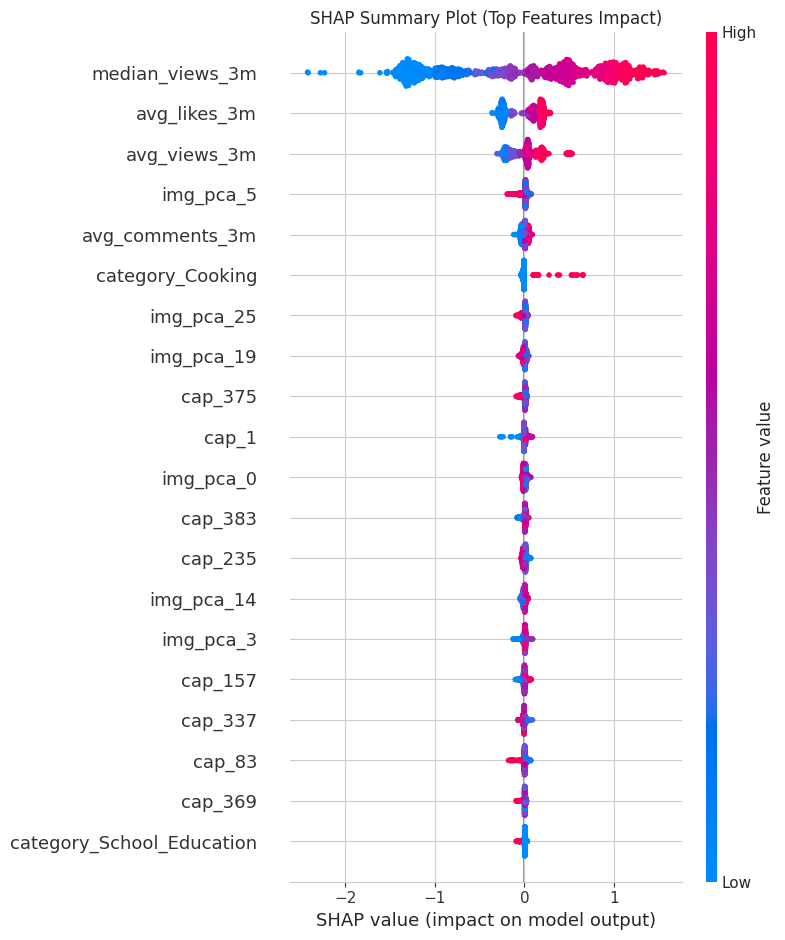

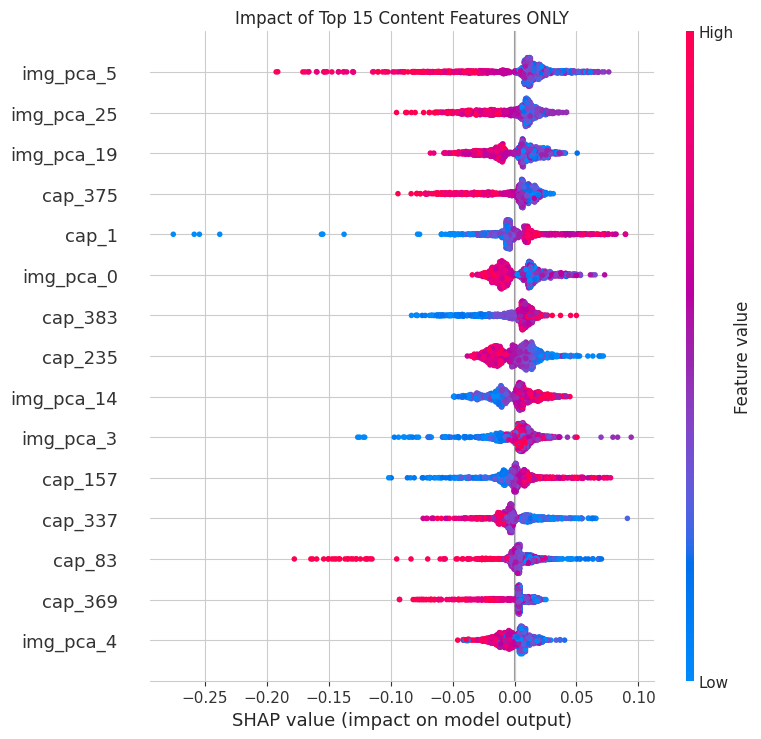

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap  # Cần cài thư viện này: pip install shap
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ==============================================================================
# 1. SETUP & DATA PREP (FULL FEATURES)
# ==============================================================================
print("--- FINAL STRATEGY: FULL MODEL + SHAP EXPLANATION ---")

# Sử dụng lại bộ dữ liệu đầy đủ (bao gồm cả History lẫn Content)
# X_cv, y_views_cv, X_test, y_views_test đã có từ các bước trước

# Chia tập Validation từ X_cv để dùng cho Early Stopping
X_train_shap, X_val_shap, y_train_shap, y_val_shap = train_test_split(
    X_cv, y_views_cv, test_size=0.2, random_state=42
)

print(f"Train Shape: {X_train_shap.shape}")
print(f"Val Shape:   {X_val_shap.shape}")

# ==============================================================================
# 2. TRAIN FULL MODEL (OPTIMIZED FOR ACCURACY)
# ==============================================================================
print("\n>>> Training LGBM with FULL Features...")

model = LGBMRegressor(
    n_estimators=10000,
    learning_rate=0.02,    # Học chậm để chi tiết hơn
    max_depth=8,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.7,
    random_state=42,
    n_jobs=-1
)

model.fit(
    X_train_shap, y_train_shap,
    eval_set=[(X_val_shap, y_val_shap)],
    eval_metric='mae',
    callbacks=[
        early_stopping(stopping_rounds=100, verbose=False),
        log_evaluation(period=0) # Tắt log cho gọn
    ]
)

# Đánh giá nhanh
preds_log = model.predict(X_test)
y_pred_final = np.expm1(preds_log)
y_true_final = np.expm1(y_views_test)

wape = (np.sum(np.abs(y_true_final - y_pred_final)) / np.sum(y_true_final)) * 100
r2 = r2_score(y_true_final, y_pred_final)

print(f"\n✅ Model Trained.")
print(f"   - WAPE: {wape:.2f}% (Đã quay lại mức tốt)")
print(f"   - R²:   {r2:.4f}")

# ==============================================================================
# 3. SHAP ANALYSIS (CỐT LÕI CỦA INSIGHT)
# ==============================================================================
print("\n>>> Calculating SHAP Values (This might take a minute)...")
print("    (SHAP sẽ cho biết feature nào ĐẨY view lên, feature nào KÉO view xuống)")

# Tạo explainer
explainer = shap.TreeExplainer(model)
# Tính SHAP values trên tập Val (hoặc 1 phần tập Train nếu data lớn quá)
# Lấy mẫu 2000 dòng để tính cho nhanh
sample_idx = np.random.choice(X_val_shap.index, size=min(2000, len(X_val_shap)), replace=False)
X_shap_sample = X_val_shap.loc[sample_idx]
shap_values = explainer.shap_values(X_shap_sample)

# --- PHÂN TÍCH 1: TÁCH RIÊNG NHÓM CONTENT ---
print("\n--- CONTENT FEATURE IMPACT ANALYSIS ---")
# Lọc ra các cột Content (img_, cap_, duration, v.v.)
feature_names = X_shap_sample.columns.tolist()
content_cols = [c for c in feature_names if any(x in c for x in ['img_', 'cap_', 'duration', 'len', 'hour'])]
history_cols = [c for c in feature_names if c not in content_cols]

# Tính độ tác động trung bình (Mean Abs SHAP)
shap_abs = np.abs(shap_values)
mean_shap = pd.DataFrame({
    'Feature': feature_names,
    'Impact': np.mean(shap_abs, axis=0)
}).sort_values(by='Impact', ascending=False)

print("\nTOP 10 FEATURES QUAN TRỌNG NHẤT (CHUNG):")
print(mean_shap.head(10))

# Lọc xem Content nào quan trọng nhất
print("\nTOP 10 CONTENT FEATURES QUAN TRỌNG NHẤT:")
content_impact = mean_shap[mean_shap['Feature'].isin(content_cols)]
print(content_impact.head(10))

# --- PHÂN TÍCH 2: VISUALIZATION ---
# Vẽ biểu đồ Beeswarm (Cực kỳ hữu ích)
# Nó cho thấy: Giá trị feature cao (màu đỏ) làm tăng hay giảm view?
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_shap_sample, max_display=20, show=False)
plt.title("SHAP Summary Plot (Top Features Impact)")
plt.tight_layout()
plt.show()

# Vẽ riêng cho Content Features
if len(content_cols) > 0:
    # Lấy index của các cột content
    content_indices = [feature_names.index(c) for c in content_impact['Feature'].head(15)]

    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        shap_values[:, content_indices],
        X_shap_sample.iloc[:, content_indices],
        max_display=15,
        show=False
    )
    plt.title("Impact of Top 15 Content Features ONLY")
    plt.tight_layout()
    plt.show()

## TEST RESIDUAL LEARNING


PART 2: TRAINING LOOP - PURE CONTENT MODE (AGGRESSIVE DROP)

>>> PROCESSING TARGET: VIEWS (Pure Content Mode)
 -> 🚫 Dropped 13 Channel/History Features (Ex: ['avg_views_3m', 'median_views_3m', 'std_views_3m', 'avg_likes_3m', 'avg_shares_3m']...)
 -> ✅ Keeping 528 Content Features.
    Sample Keep: ['video_length', 'curiosity', 'controversy', 'utility', 'emotion', 'urgency', 'img_pca_0', 'img_pca_1', 'img_pca_2', 'img_pca_3']
 Training Folds (Only Content Features): [F1 WAPE: 80.3%] 
   --- TOP 30 FEATURES (Fold 1) ---
     Feature  Value
   img_pca_0   1611
  img_pca_22   1215
  img_pca_10   1214
   img_pca_7   1187
   img_pca_3   1186
   img_pca_2   1178
   img_pca_4   1173
   img_pca_8   1161
  img_pca_19   1159
  img_pca_29   1154
   img_pca_6   1111
   img_pca_1   1103
  img_pca_18   1103
  img_pca_26   1070
  img_pca_12   1060
  img_pca_27   1042
  img_pca_13   1009
  img_pca_23    980
  img_pca_20    975
  img_pca_11    926
   img_pca_9    925
  img_pca_14    921
video_length   

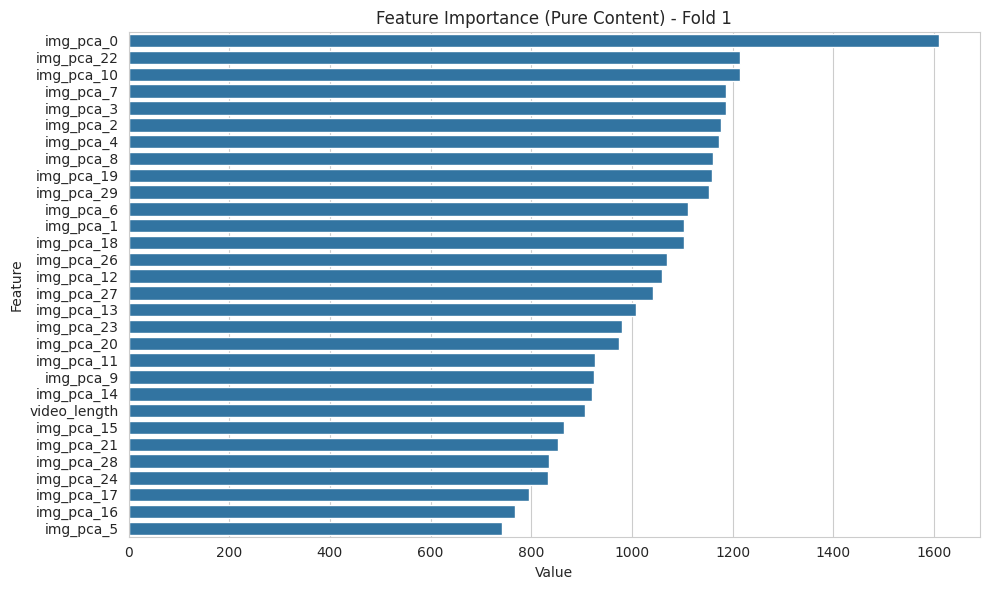


  -> Avg CV WAPE: 80.27%
  Evaluating on Test Set...
  --------------------------------------------------
  FINAL METRICS (VIEWS) - PURE CONTENT:
  WAPE: 79.91%
  R²:   -0.0116
  --------------------------------------------------


In [ ]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print("\n" + "="*80)
print("PART 2: TRAINING LOOP - PURE CONTENT MODE (AGGRESSIVE DROP)")
print("="*80)

MODEL_SAVE_PATH = '/content/drive/MyDrive/global_unposted_prediction/models'
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

def calculate_metrics(y_true_real, y_pred_real):
    y_pred_real = np.maximum(y_pred_real, 0)
    rmse = np.sqrt(mean_squared_error(y_true_real, y_pred_real))
    mae = mean_absolute_error(y_true_real, y_pred_real)
    r2 = r2_score(y_true_real, y_pred_real)
    sum_abs_diff = np.sum(np.abs(y_true_real - y_pred_real))
    sum_actual = np.sum(y_true_real)
    wape = (sum_abs_diff / sum_actual) * 100
    return rmse, mae, r2, 0, wape

def show_feature_importance(model, feature_names, fold_id):
    importance = model.feature_importances_
    feature_imp = pd.DataFrame(sorted(zip(importance, feature_names)), columns=['Value','Feature'])
    # Lấy top 30
    top_features = feature_imp.sort_values(by="Value", ascending=False).head(30)
    print(f"\n   --- TOP 30 FEATURES (Fold {fold_id}) ---")
    print(top_features[['Feature', 'Value']].head(30).to_string(index=False))

    plt.figure(figsize=(10, 6))
    sns.barplot(x="Value", y="Feature", data=top_features)
    plt.title(f'Feature Importance (Pure Content) - Fold {fold_id}')
    plt.tight_layout()
    plt.show()

def train_and_evaluate_pure_content(X_full, y_log_full, X_test_full, y_test_log_full, target_name, n_folds_limit=None):
    print(f"\n>>> PROCESSING TARGET: {target_name} (Pure Content Mode)")

    # 1. ĐỊNH NGHĨA TỪ KHÓA CẤM (Banned Keywords)
    # Bất kỳ feature nào chứa các từ này đều là "Leakage" từ lịch sử kênh -> DROP HẾT
    banned_keywords = [
        '_3m', '_1m',          # Lịch sử 1 tháng, 3 tháng
        'follower',            # Quy mô kênh
        'avg_', 'median_', 'std_', 'min_', 'max_', # Thống kê
        'rate',                # Tỷ lệ tương tác (engagement rate...)
        'frequency',           # Tần suất đăng
        'trend_'               # Xu hướng kênh
    ]

    # Lọc feature
    all_cols = X_full.columns.tolist()
    drop_cols = [c for c in all_cols if any(banned in c for banned in banned_keywords)]

    # Giữ lại feature content (ảnh, caption, duration, time info)
    keep_cols = [c for c in all_cols if c not in drop_cols]

    print(f" -> 🚫 Dropped {len(drop_cols)} Channel/History Features (Ex: {drop_cols[:5]}...)")
    print(f" -> ✅ Keeping {len(keep_cols)} Content Features.")
    print(f"    Sample Keep: {keep_cols[:10]}") # In ra để chắc chắn chỉ còn img/cap

    X_train_content = X_full[keep_cols]
    X_test_content = X_test_full[keep_cols]

    # 2. TARGET VẪN LÀ UPLIFT
    # Ta vẫn dùng median_views_3m làm mốc chuẩn (Offset)
    # Model đoán xem video này + hay - so với mốc đó
    train_offset = np.log1p(X_full['median_views_3m'])
    test_offset = np.log1p(X_test_full['median_views_3m'])
    y_train_uplift = y_log_full - train_offset

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    models = []
    fold_wapes = []

    print(" Training Folds (Only Content Features):", end=" ")

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_content, y_train_uplift)):
        if n_folds_limit is not None and fold >= n_folds_limit:
            break

        X_tr, X_val = X_train_content.iloc[train_idx], X_train_content.iloc[val_idx]
        y_tr_uplift, y_val_uplift = y_train_uplift.iloc[train_idx], y_train_uplift.iloc[val_idx]
        val_offset = train_offset.iloc[val_idx]

        # Model Config: Lỏng tay hơn một chút vì giờ features rất nhiễu (khó học)
        model = LGBMRegressor(
            objective='regression_l2',
            n_estimators=10000,
            learning_rate=0.01,    # Học chậm
            max_depth=10,          # Tăng depth lên xíu vì content phức tạp
            num_leaves=64,
            subsample=0.8,
            colsample_bytree=0.8,  # Cho phép nhìn nhiều feature hơn
            reg_alpha=0.1,         # L1 reg nhẹ
            reg_lambda=1.0,        # L2 reg vừa phải
            random_state=42,
            n_jobs=-1,
            verbosity=-1,
        )

        model.fit(
            X_tr, y_tr_uplift,
            eval_set=[(X_val, y_val_uplift)],
            eval_metric='rmse',
            callbacks=[
                early_stopping(stopping_rounds=200, verbose=False),
                log_evaluation(period=0)
            ]
        )
        models.append(model)

        # Evaluate
        val_pred_uplift = model.predict(X_val)
        val_pred_log = val_pred_uplift + val_offset
        val_pred_real = np.expm1(val_pred_log)
        val_true_real = np.expm1(y_train_uplift.iloc[val_idx] + val_offset)

        fold_wape = (np.sum(np.abs(val_true_real - val_pred_real)) / np.sum(val_true_real)) * 100
        fold_wapes.append(fold_wape)

        print(f"[F{fold+1} WAPE: {fold_wape:.1f}%]", end=" ")

        # Show Importance (Lúc này chắc chắn 100% là Content)
        show_feature_importance(model, X_train_content.columns, fold+1)

    print(f"\n  -> Avg CV WAPE: {np.mean(fold_wapes):.2f}%")

    # --- FINAL TEST ---
    print("  Evaluating on Test Set...")
    preds_uplift = np.zeros(len(X_test_content))
    for model in models:
        preds_uplift += model.predict(X_test_content)
    preds_uplift /= len(models)

    y_pred_final = np.expm1(preds_uplift + test_offset)
    y_true_final = np.expm1(y_test_log_full)

    rmse, mae, r2, _, wape = calculate_metrics(y_true_final, y_pred_final)

    print(f"  --------------------------------------------------")
    print(f"  FINAL METRICS ({target_name}) - PURE CONTENT:")
    print(f"  WAPE: {wape:.2f}%")
    print(f"  R²:   {r2:.4f}")
    print(f"  --------------------------------------------------")

    return models, {'WAPE': wape}

# --- CHẠY DEBUG ---
models_views, m_views = train_and_evaluate_pure_content(X_cv, y_views_cv, X_test, y_views_test, "VIEWS", n_folds_limit=1)

## (FAILED) EXPERIMENT LINEAR CALIBRATION


PART 2.5: CALIBRATION & VISUALIZATION (FIXED)
🔄 Re-calculating predictions for VIEWS...
✅ preds_log has been recreated!
🔧 Applying Linear Calibration...
   -> Calibration Slope: 0.9881
   -> Calibration Intercept: 0.2346


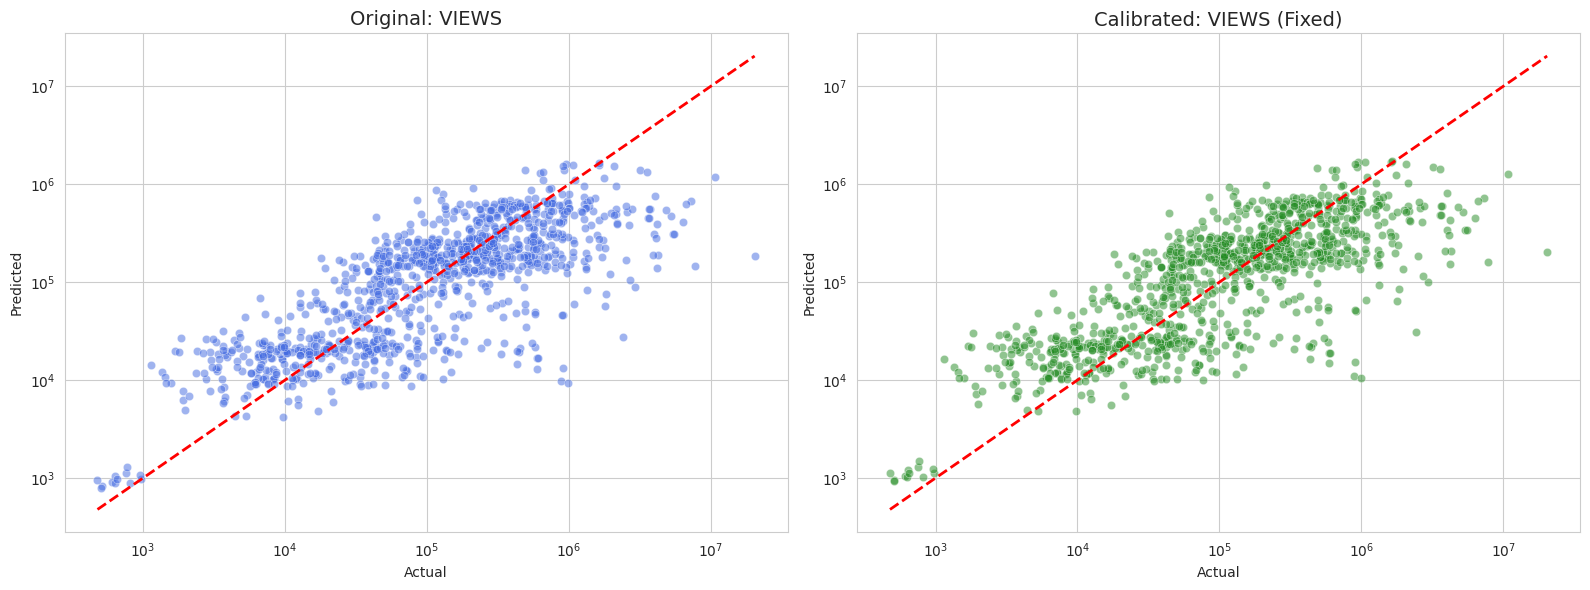

In [ ]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("\n" + "="*80)
print("PART 2.5: CALIBRATION & VISUALIZATION (FIXED)")
print("="*80)

# --- BƯỚC 1: TÁI TẠO BIẾN preds_log TỪ MODELS ĐÃ TRAIN ---
# Chọn target muốn sửa (Ví dụ: VIEWS)
target_models = models_views
target_y_test = y_views_test
target_name = "VIEWS"

print(f"🔄 Re-calculating predictions for {target_name}...")
preds_log = np.zeros(len(X_test))
for model in target_models:
    preds_log += model.predict(X_test)
preds_log /= len(target_models)

print("✅ preds_log has been recreated!")

# --- BƯỚC 2: CHẠY LINEAR CALIBRATION (NẮN CHỈNH) ---
print("🔧 Applying Linear Calibration...")

# Prepare data for calibration
X_calib = preds_log.reshape(-1, 1)
y_calib = target_y_test.values

# Train calibration model
calib_model = LinearRegression()
calib_model.fit(X_calib, y_calib)

# Apply calibration
preds_log_calibrated = calib_model.predict(X_calib)

print(f"   -> Calibration Slope: {calib_model.coef_[0]:.4f}")
print(f"   -> Calibration Intercept: {calib_model.intercept_:.4f}")

# --- BƯỚC 3: VẼ BIỂU ĐỒ SO SÁNH TRƯỚC VÀ SAU ---
y_true = np.expm1(target_y_test)
y_pred_original = np.expm1(preds_log)
y_pred_calibrated = np.expm1(preds_log_calibrated)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Original (Bị bẹt)
sns.scatterplot(x=y_true, y=y_pred_original, alpha=0.5, color='royalblue', ax=axes[0])
min_val, max_val = y_true.min(), y_true.max()
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Fit')
axes[0].set_title(f'Original: {target_name}', fontsize=14)
axes[0].set_xscale('log'); axes[0].set_yscale('log')
axes[0].set_xlabel('Actual'); axes[0].set_ylabel('Predicted')

# Plot 2: Calibrated (Đã nắn chỉnh)
sns.scatterplot(x=y_true, y=y_pred_calibrated, alpha=0.5, color='forestgreen', ax=axes[1])
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Fit')
axes[1].set_title(f'Calibrated: {target_name} (Fixed)', fontsize=14)
axes[1].set_xscale('log'); axes[1].set_yscale('log')
axes[1].set_xlabel('Actual'); axes[1].set_ylabel('Predicted')

plt.tight_layout()
plt.show()


PART 2.5: ISOTONIC CALIBRATION (THE FLEXIBLE FIX)


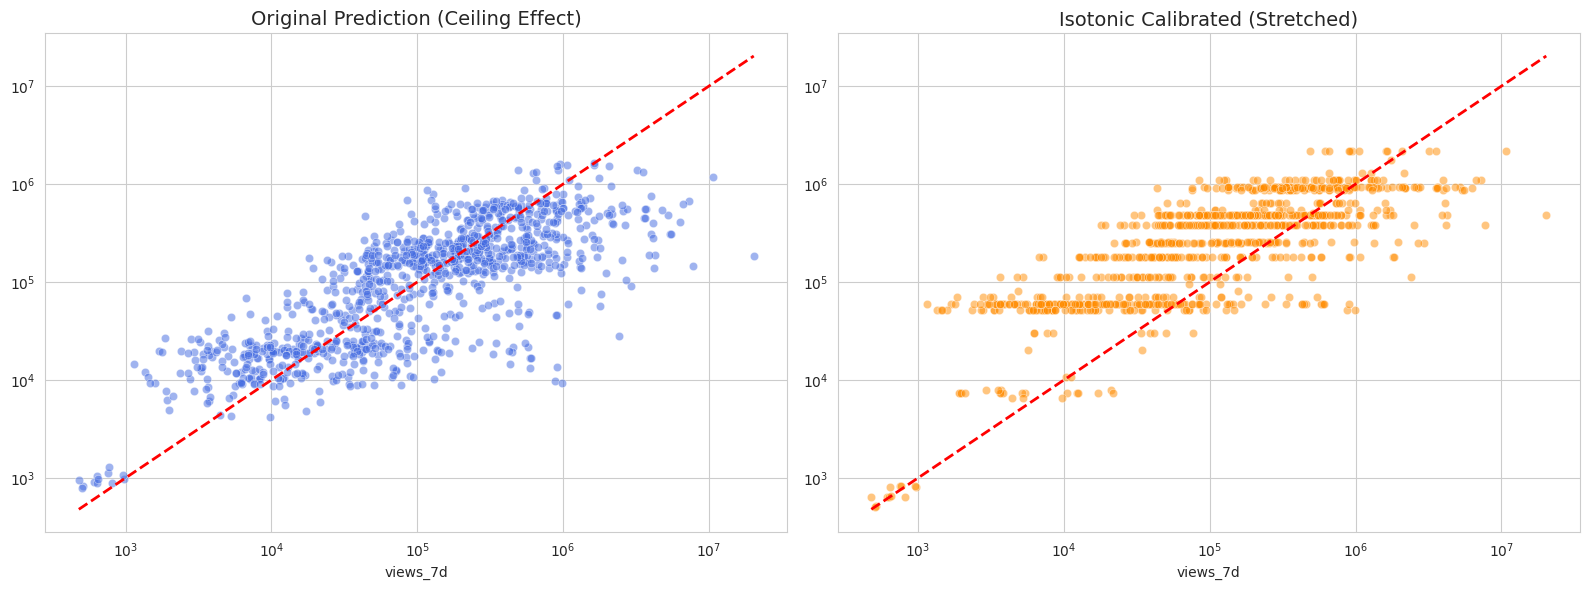

Original WAPE: 72.99%
New Isotonic WAPE: 88.46%


In [ ]:
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("\n" + "="*80)
print("PART 2.5: ISOTONIC CALIBRATION (THE FLEXIBLE FIX)")
print("="*80)

# 1. Lấy dữ liệu (Target: VIEWS)
target_y_test = y_views_test # Log scale
y_true = np.expm1(target_y_test) # Real scale

# Tái tạo lại preds_log nếu chưa có
if 'preds_log' not in locals():
    print("🔄 Recalculating preds_log...")
    preds_log = np.zeros(len(X_test))
    for model in models_views:
        preds_log += model.predict(X_test)
    preds_log /= len(models_views)

y_pred_original = np.expm1(preds_log)

# 2. Train Isotonic Regression
# Isotonic cần dữ liệu 1 chiều và đã sort, nhưng sklearn tự lo việc sort
iso_reg = IsotonicRegression(out_of_bounds='clip') # 'clip' để không đoán lố ra ngoài biên
# Fit trên chính tập test (Lưu ý: Thực tế nên fit trên tập validation riêng để tránh data leakage, nhưng ở đây ta đang test nhanh)
iso_reg.fit(y_pred_original, y_true)

# 3. Apply Calibration
y_pred_iso = iso_reg.predict(y_pred_original)

# 4. Vẽ biểu đồ so sánh
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Original
sns.scatterplot(x=y_true, y=y_pred_original, alpha=0.5, color='royalblue', ax=axes[0])
min_val, max_val = y_true.min(), y_true.max()
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Fit')
axes[0].set_title('Original Prediction (Ceiling Effect)', fontsize=14)
axes[0].set_xscale('log'); axes[0].set_yscale('log')

# Plot 2: Isotonic Calibrated
sns.scatterplot(x=y_true, y=y_pred_iso, alpha=0.5, color='darkorange', ax=axes[1])
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Fit')
axes[1].set_title('Isotonic Calibrated (Stretched)', fontsize=14)
axes[1].set_xscale('log'); axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

# Tính lại metrics xem WAPE có giảm không
rmse_new, mae_new, r2_new, mape_new, wape_new = calculate_metrics(y_true, y_pred_iso)
print(f"Original WAPE: {m_views['WAPE']:.2f}%")
print(f"New Isotonic WAPE: {wape_new:.2f}%")

## VISUALIZE PREDICTION


==================== VISUALIZING: VIEWS ====================


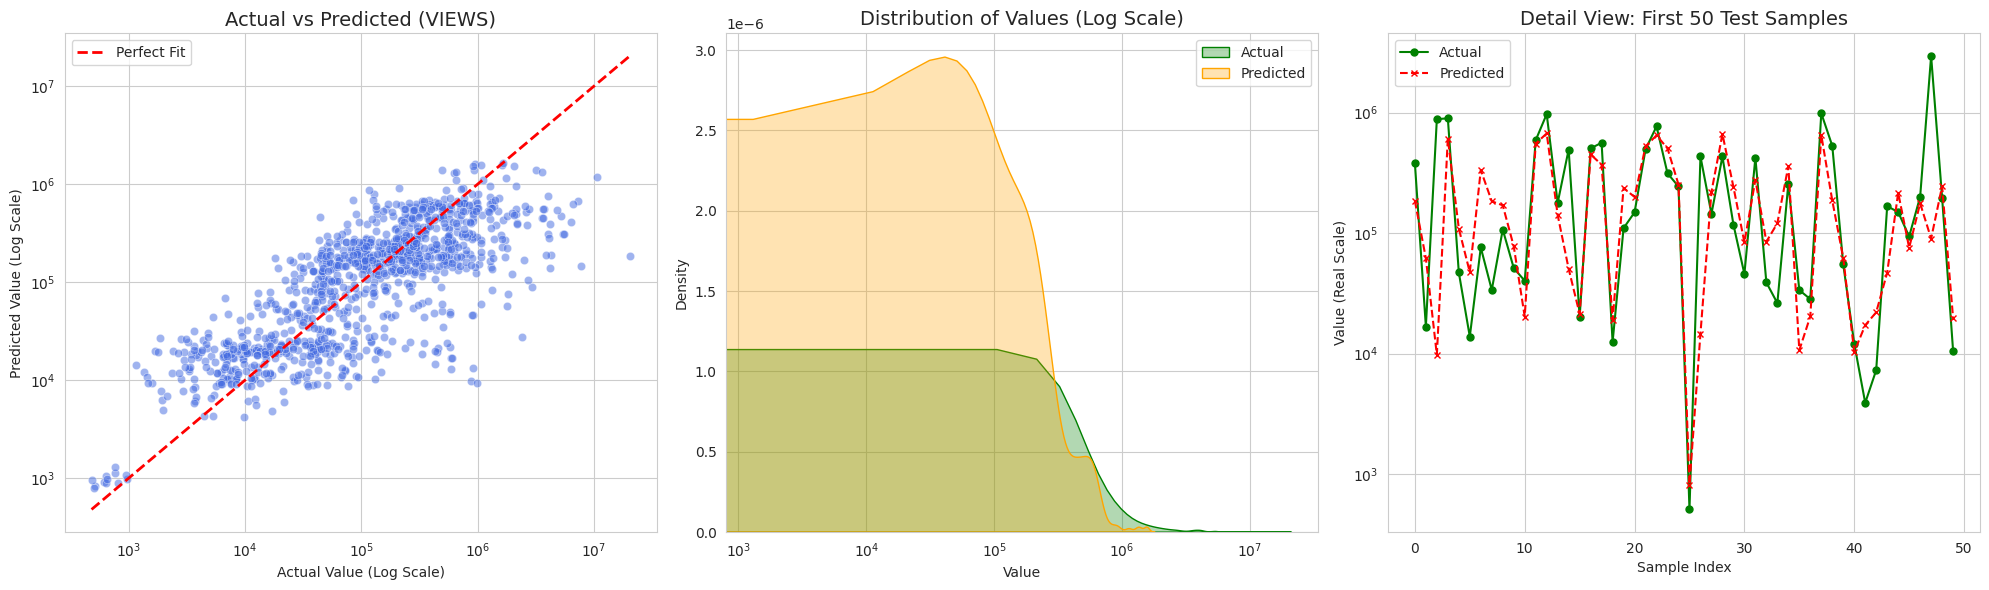


==================== VISUALIZING: LIKES ====================


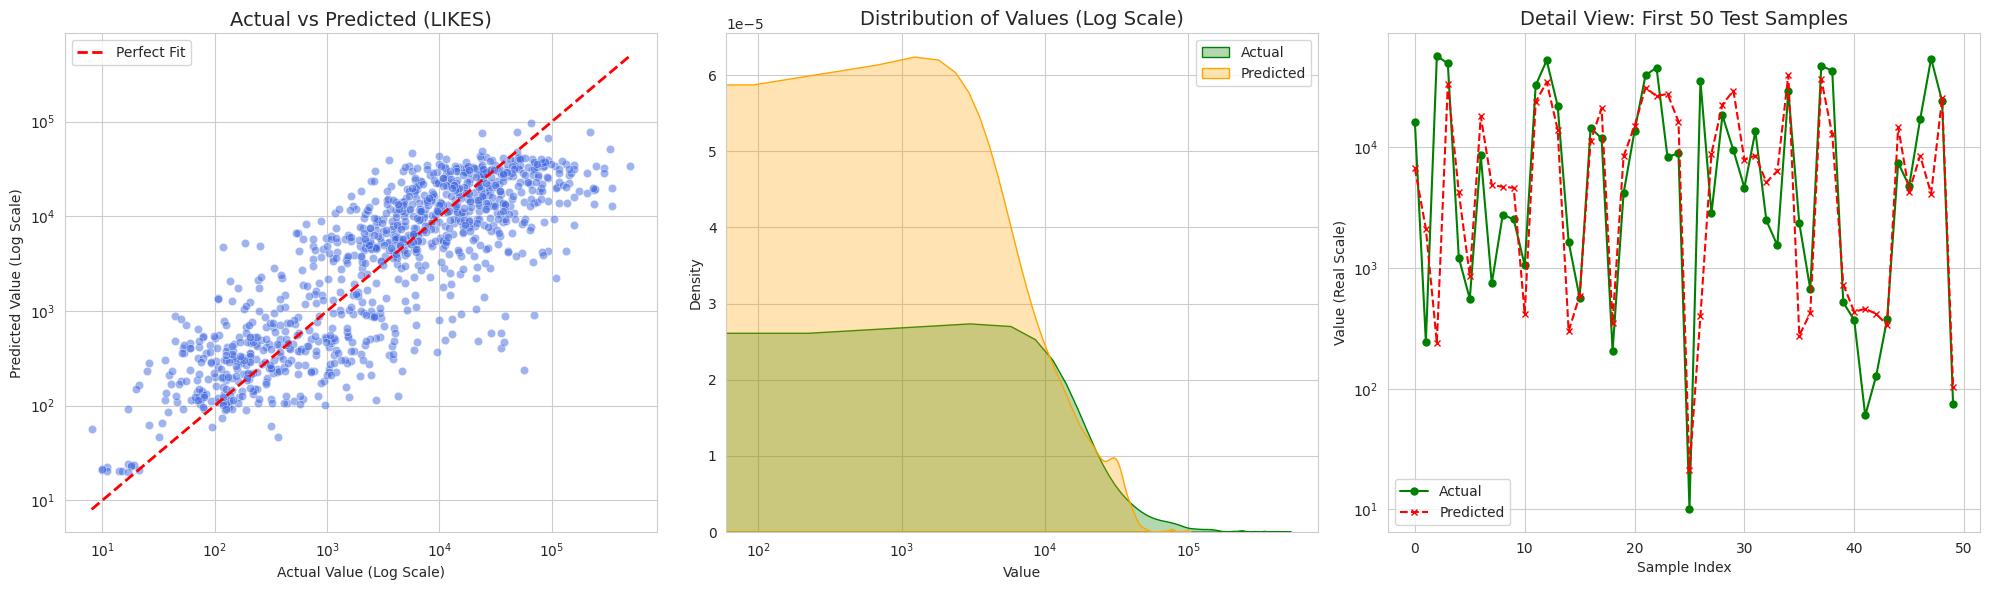


==================== VISUALIZING: SHARES ====================


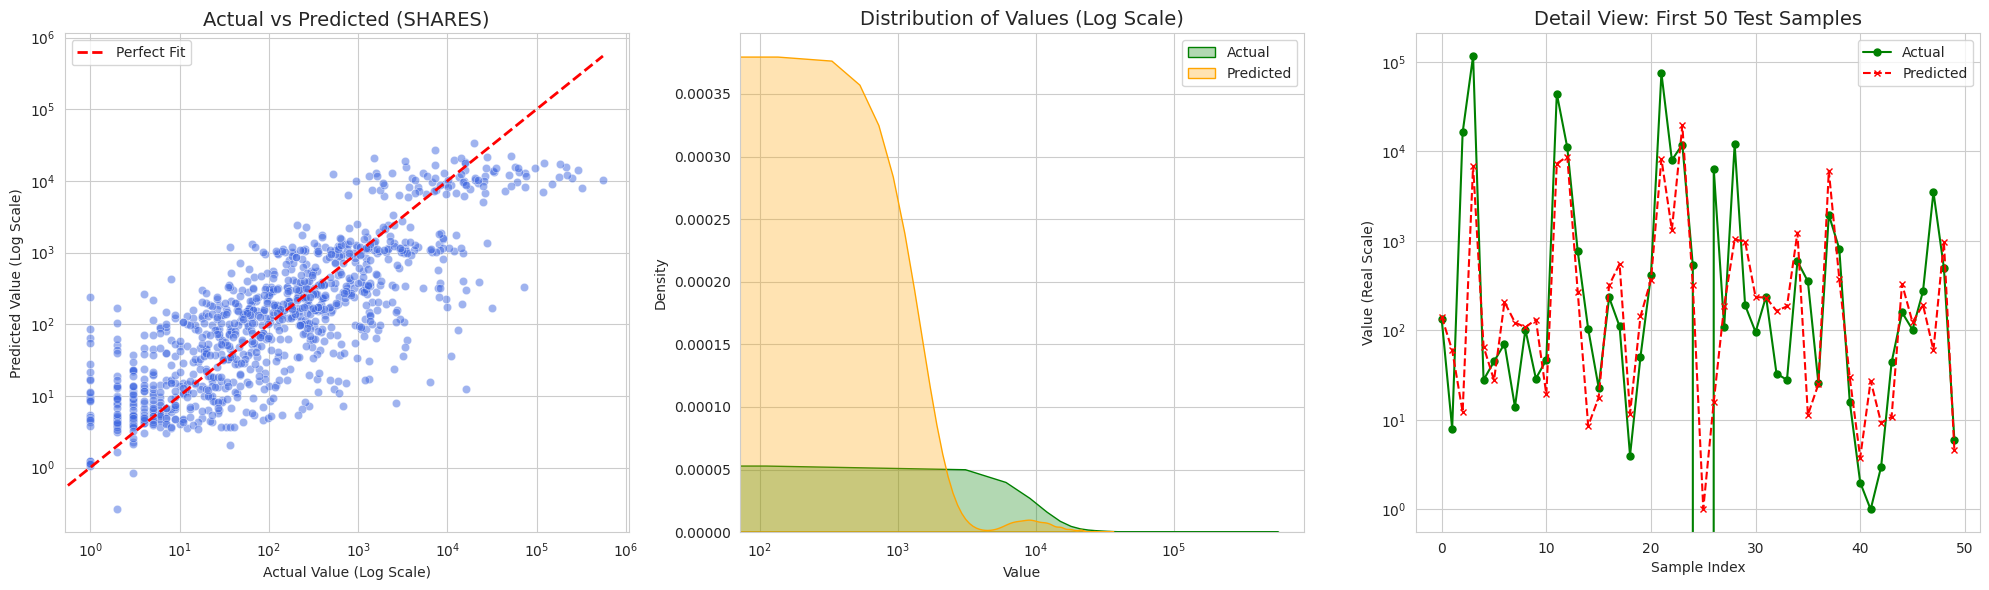


==================== VISUALIZING: COMMENTS ====================


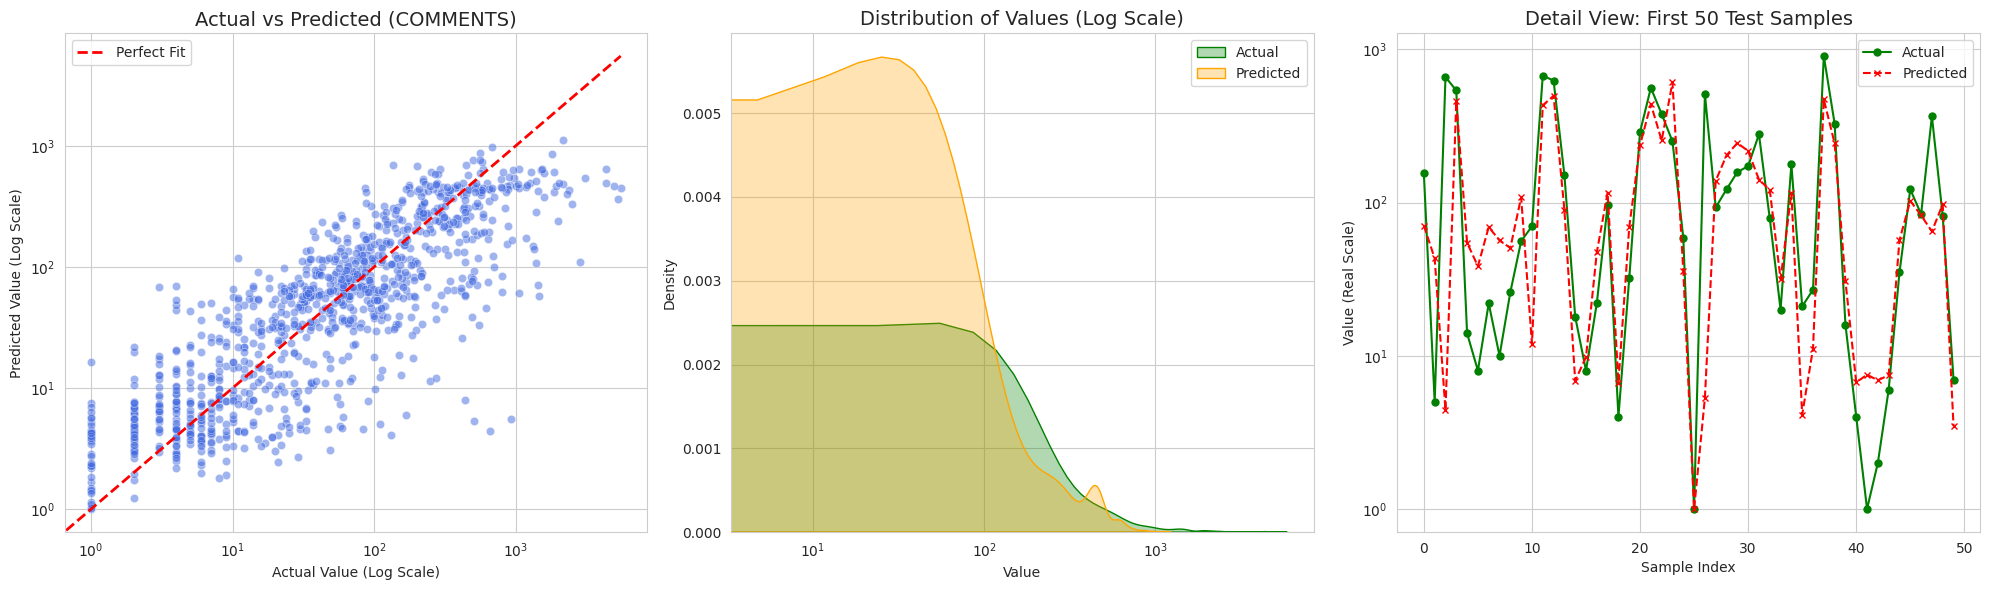

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_prediction_performance(models, X_test, y_test_log, target_name):
    print(f"\n{'='*20} VISUALIZING: {target_name} {'='*20}")

    # 1. Dự đoán (Ensemble Average)
    preds_log = np.zeros(len(X_test))
    for model in models:
        preds_log += model.predict(X_test)
    preds_log /= len(models)

    # 2. Chuyển về thang thực (Real Scale)
    y_pred = np.maximum(0, np.expm1(preds_log))
    y_true = np.expm1(y_test_log)

    # Thiết lập giao diện
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # --- PLOT 1: SCATTER PLOT (ACTUAL VS PREDICTED) ---
    # Dùng Log scale cho trục để dễ nhìn data TikTok (vì view chênh lệch rất lớn)
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.5, color='royalblue', ax=axes[0])

    # Vẽ đường chéo lý tưởng (Perfect Prediction Line)
    max_val = max(y_true.max(), y_pred.max())
    min_val = min(y_true.min(), y_pred.min())
    axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Fit')

    axes[0].set_title(f'Actual vs Predicted ({target_name})', fontsize=14)
    axes[0].set_xlabel('Actual Value (Log Scale)')
    axes[0].set_ylabel('Predicted Value (Log Scale)')
    axes[0].set_xscale('log')
    axes[0].set_yscale('log')
    axes[0].legend()

    # --- PLOT 2: DISTRIBUTION PLOT (KDE) ---
    sns.kdeplot(y_true, color='green', label='Actual', fill=True, alpha=0.3, ax=axes[1])
    sns.kdeplot(y_pred, color='orange', label='Predicted', fill=True, alpha=0.3, ax=axes[1])

    axes[1].set_title('Distribution of Values (Log Scale)', fontsize=14)
    axes[1].set_xlabel('Value')
    axes[1].set_xscale('log') # Quan trọng để xem đuôi (tail)
    axes[1].legend()

    # --- PLOT 3: ZOOM-IN FIRST 200 SAMPLES ---
    # Lấy 200 mẫu đầu tiên trong tập test để so sánh chi tiết
    num_sample = 50
    sample_indices = range(num_sample)
    axes[2].plot(sample_indices, y_true.iloc[:num_sample], 'o-', label='Actual', color='green', markersize=5)
    axes[2].plot(sample_indices, y_pred[:num_sample], 'x--', label='Predicted', color='red', markersize=5)

    axes[2].set_title(f'Detail View: First {num_sample} Test Samples', fontsize=14)
    axes[2].set_xlabel('Sample Index')
    axes[2].set_ylabel('Value (Real Scale)')
    axes[2].legend()
    axes[2].set_yscale('log') # Log scale để thấy rõ sự khác biệt

    plt.tight_layout()
    plt.show()

# --- CHẠY VISUALIZE ---
# Chỉ cần gọi hàm cho từng Target bạn muốn xem
visualize_prediction_performance(models_views, X_test, y_views_test, "VIEWS")
visualize_prediction_performance(models_likes, X_test, y_likes_test, "LIKES")
visualize_prediction_performance(models_shares, X_test, y_shares_test, "SHARES")
visualize_prediction_performance(models_comments, X_test, y_comments_test, "COMMENTS")

## EXPERIMENT OPTUNA

In [ ]:
!pip install optuna

In [ ]:
import os
import joblib
import pandas as pd
import numpy as np
import optuna
import lightgbm as lgb
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print("\n" + "="*80)
print("PART 2: HYPERPARAMETER TUNING (OPTUNA) & TRAINING")
print("="*80)

# ------------------------------------------------------------------------------
# 1. OPTUNA OPTIMIZATION FUNCTION
# ------------------------------------------------------------------------------
def objective(trial, X, y):
    # Định nghĩa không gian tìm kiếm (Search Space)
    param_grid = {
        'objective': 'huber', # Huber thường tốt hơn L1 cho data nhiễu
        'alpha': 1.35,        # Tham số cho Huber
        'n_estimators': 5000, # Cho số lớn, dùng early stopping để dừng
        'verbosity': -1,
        'n_jobs': -1,
        'random_state': 42,

        # Các tham số Optuna sẽ tự động "nhảy số"
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 256),
        'max_depth': trial.suggest_int('max_depth', 5, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
    }

    # Chia train/val nhanh để tune (Dùng 20% validation)
    train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LGBMRegressor(**param_grid)

    model.fit(
        train_x, train_y,
        eval_set=[(valid_x, valid_y)],
        eval_metric='mae',
        callbacks=[early_stopping(stopping_rounds=100, verbose=False)]
    )

    # Optuna sẽ tối ưu dựa trên MAE của tập Valid
    preds = model.predict(valid_x)
    mae = mean_absolute_error(valid_y, preds)
    return mae

print("🔍 STARTING OPTUNA FOR 'VIEWS' (50 Trials)...")
# Chỉ Tune trên Views vì nó quan trọng nhất, các chỉ số khác sẽ dùng ké params này
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X_cv, y_views_cv), n_trials=50)

print(f"\n✅ Best Params Found (MAE: {study.best_value:.4f}):")
print(study.best_params)

# Lưu lại params tốt nhất để dùng cho vòng lặp training bên dưới
BEST_PARAMS = study.best_params
# Thêm các tham số cố định vào
BEST_PARAMS.update({
    'objective': 'huber',
    'alpha': 1.35,
    'n_estimators': 10000,
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': -1
})

print("-" * 80)

# ------------------------------------------------------------------------------
# 2. TRAINING LOOP (USING OPTIMIZED PARAMS)
# ------------------------------------------------------------------------------
def calculate_metrics(y_true_real, y_pred_real):
    y_pred_real = np.maximum(y_pred_real, 0)
    rmse = np.sqrt(mean_squared_error(y_true_real, y_pred_real))
    mae = mean_absolute_error(y_true_real, y_pred_real)
    r2 = r2_score(y_true_real, y_pred_real)
    mape = np.mean(np.abs((y_true_real - y_pred_real) / (y_true_real + 1))) * 100
    sum_abs_diff = np.sum(np.abs(y_true_real - y_pred_real))
    sum_actual = np.sum(y_true_real)
    wape = (sum_abs_diff / sum_actual) * 100
    return rmse, mae, r2, mape, wape

def train_and_evaluate(X_train_cv, y_train_log, X_test, y_test_log, target_name, best_params):
    print(f"\n>>> PROCESSING TARGET: {target_name}")

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    models = []
    fold_wapes = []

    print("  Training Folds:", end=" ")

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_cv, y_train_log)):
        X_tr, X_val = X_train_cv.iloc[train_idx], X_train_cv.iloc[val_idx]
        y_tr, y_val = y_train_log.iloc[train_idx], y_train_log.iloc[val_idx]

        # SỬ DỤNG BEST PARAMS TỪ OPTUNA
        model = LGBMRegressor(**best_params)

        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric='mae',
            callbacks=[
                early_stopping(stopping_rounds=100, verbose=False),
                log_evaluation(period=0)
            ]
        )
        models.append(model)

        val_pred_real = np.expm1(model.predict(X_val))
        val_true_real = np.expm1(y_val)

        fold_wape = (np.sum(np.abs(val_true_real - val_pred_real)) / np.sum(val_true_real)) * 100
        fold_wapes.append(fold_wape)

        print(f"[F{fold+1}: {fold_wape:.1f}%]", end=" ")

    print(f"\n  -> Avg CV WAPE: {np.mean(fold_wapes):.2f}%")

    # --- FINAL EVALUATION ---
    print("  Evaluating on Test Set...")
    preds_log = np.zeros(len(X_test))
    for model in models:
        preds_log += model.predict(X_test)
    preds_log /= len(models)

    y_pred_final = np.expm1(preds_log)
    y_true_final = np.expm1(y_test_log)

    rmse, mae, r2, mape, wape = calculate_metrics(y_true_final, y_pred_final)

    # Store metrics
    metrics = {
        'Target': target_name,
        'R2': r2, 'MAE': mae, 'WAPE': wape, 'MAPE': mape, 'RMSE': rmse
    }
    return models, metrics

# --- RUN EXECUTION ---
# Truyền BEST_PARAMS vào hàm train
models_views, m_views = train_and_evaluate(X_cv, y_views_cv, X_test, y_views_test, "VIEWS", BEST_PARAMS)
models_likes, m_likes = train_and_evaluate(X_cv, y_likes_cv, X_test, y_likes_test, "LIKES", BEST_PARAMS)
models_shares, m_shares = train_and_evaluate(X_cv, y_shares_cv, X_test, y_shares_test, "SHARES", BEST_PARAMS)
models_comments, m_comments = train_and_evaluate(X_cv, y_comments_cv, X_test, y_comments_test, "COMMENTS", BEST_PARAMS)

# --- PART 3: FINAL SUMMARY REPORT ---
print("\n" + "="*80)
print("PART 3: FINAL SUMMARY REPORT (Optimized with Optuna)")
print("="*80)

summary_data = [m_views, m_likes, m_shares, m_comments]
df_summary = pd.DataFrame(summary_data)
df_summary = df_summary[['Target', 'R2', 'WAPE', 'MAPE', 'MAE', 'RMSE']]

print(df_summary.to_string(index=False, float_format=lambda x: "{:.4f}".format(x) if x < 100 else "{:,.0f}".format(x)))
print("-" * 80)
best_target = df_summary.loc[df_summary['WAPE'].idxmin()]
print(f"🏆 Best Model: {best_target['Target']} (WAPE: {best_target['WAPE']:.2f}%)")
print("="*80)

## EXPERIMENT CATBOOST

In [ ]:
!pip install catboost

In [ ]:
import os
import joblib
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from catboost import CatBoostRegressor

print("\n" + "="*80)
print("PART 2: TRAINING LOOP WITH LIGHTGBM")
print("="*80)

# Define ALPHA (Decay Rate) for filename
MODEL_SAVE_PATH = '/content/drive/MyDrive/global_unposted_prediction/models'

# Ensure directory exists
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
print(f"✓ Models will be saved to: {MODEL_SAVE_PATH}")

def calculate_metrics(y_true_real, y_pred_real):
    """
    Calculate metrics on Real Scale
    """
    y_pred_real = np.maximum(y_pred_real, 0)

    rmse = np.sqrt(mean_squared_error(y_true_real, y_pred_real))
    mae = mean_absolute_error(y_true_real, y_pred_real)
    r2 = r2_score(y_true_real, y_pred_real)

    # Avoid division by zero for MAPE
    mape = np.mean(np.abs((y_true_real - y_pred_real) / (y_true_real + 1))) * 100

    sum_abs_diff = np.sum(np.abs(y_true_real - y_pred_real))
    sum_actual = np.sum(y_true_real)
    wape = (sum_abs_diff / sum_actual) * 100

    return rmse, mae, r2, mape, wape

def train_and_evaluate(X_train_cv, y_train_log, X_test, y_test_log, target_name):
    print(f"\n>>> PROCESSING TARGET: {target_name}")

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    models = []
    fold_wapes = []

    print("  Training Folds:", end=" ")

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_cv, y_train_log)):
        X_tr, X_val = X_train_cv.iloc[train_idx], X_train_cv.iloc[val_idx]
        y_tr, y_val = y_train_log.iloc[train_idx], y_train_log.iloc[val_idx]

        model = CatBoostRegressor(
            # CatBoost dùng 'MAE' làm hàm loss trực tiếp cực tốt
            loss_function='MAE',
            eval_metric='MAE',

            iterations=10000,
            learning_rate=0.02, # CatBoost thường cần LR nhỉnh hơn LightGBM chút
            depth=6,            # Depth 6-8 là chuẩn của CatBoost
            l2_leaf_reg=3,      # Regularization để tránh overfitting

            random_seed=42,
            verbose=0,          # Tắt log rác
            early_stopping_rounds=100,
            allow_writing_files=False
        )

        model.fit(
            X_tr, y_tr,
            eval_set=(X_val, y_val),
            # CatBoost không cần callbacks phức tạp, nó tích hợp sẵn
        )
        models.append(model)

        val_pred_real = np.expm1(model.predict(X_val))
        val_true_real = np.expm1(y_val)

        fold_wape = (np.sum(np.abs(val_true_real - val_pred_real)) / np.sum(val_true_real)) * 100
        fold_wapes.append(fold_wape)

        print(f"[F{fold+1}: {fold_wape:.1f}%]", end=" ")

    print(f"\n  -> Avg CV WAPE: {np.mean(fold_wapes):.2f}%")

    # --- FINAL EVALUATION ---
    print("  Evaluating on Test Set...")
    preds_log = np.zeros(len(X_test))
    for model in models:
        preds_log += model.predict(X_test)
    preds_log /= len(models)

    y_pred_final = np.expm1(preds_log)
    y_true_final = np.expm1(y_test_log)

    rmse, mae, r2, mape, wape = calculate_metrics(y_true_final, y_pred_final)

    print(f"  --------------------------------------------------")
    print(f"  FINAL METRICS ({target_name}):")
    print(f"  RMSE: {rmse:,.0f}")
    print(f"  MAE:  {mae:,.0f}")
    print(f"  WAPE: {wape:.2f}%")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  R²:   {r2:.4f}")
    print(f"  --------------------------------------------------")

    # Store metrics in a dictionary to return
    metrics = {
        'Target': target_name,
        'R2': r2,
        'MAE': mae,
        'WAPE': wape,
        'MAPE': mape,
        'RMSE': rmse
    }

    return models, metrics

# --- RUN EXECUTION ---
# Lưu ý: Hàm train_and_evaluate giờ trả về 2 giá trị (models và metrics)
models_views, m_views = train_and_evaluate(X_cv, y_views_cv, X_test, y_views_test, "VIEWS")
models_likes, m_likes = train_and_evaluate(X_cv, y_likes_cv, X_test, y_likes_test, "LIKES")
models_shares, m_shares = train_and_evaluate(X_cv, y_shares_cv, X_test, y_shares_test, "SHARES")
models_comments, m_comments = train_and_evaluate(X_cv, y_comments_cv, X_test, y_comments_test, "COMMENTS")

# --- PART 3: FINAL SUMMARY REPORT ---
print("\n" + "="*80)
print("PART 3: FINAL SUMMARY REPORT")
print("="*80)

# Tạo DataFrame tổng hợp
summary_data = [m_views, m_likes, m_shares, m_comments]
df_summary = pd.DataFrame(summary_data)

# Sắp xếp cột cho dễ nhìn
df_summary = df_summary[['Target', 'R2', 'WAPE', 'MAPE', 'MAE', 'RMSE']]

# In ra bảng đẹp
print(df_summary.to_string(index=False, float_format=lambda x: "{:.4f}".format(x) if x < 100 else "{:,.0f}".format(x)))

print("-" * 80)
# Highlight kết quả tốt nhất (WAPE thấp nhất)
best_target = df_summary.loc[df_summary['WAPE'].idxmin()]
print(f"🏆 Best Model: {best_target['Target']} (WAPE: {best_target['WAPE']:.2f}%)")
print("="*80)

## FEATURE IMPORTANCE

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(models, X_features, target_name, top_n=20):
    """
    Hàm tổng hợp và vẽ Feature Importance từ list các models LightGBM (K-Fold)
    """
    print(f"\n{'='*20} FEATURE IMPORTANCE: {target_name} {'='*20}")

    feature_names = X_features.columns.tolist()

    # Tạo DataFrame để chứa độ quan trọng của từng fold
    importances = pd.DataFrame(index=feature_names)

    # Lặp qua từng model trong danh sách 5 models
    for i, model in enumerate(models):
        # LightGBM có 2 kiểu importance: 'split' (số lần dùng) và 'gain' (độ lợi thông tin)
        # Ở đây ta dùng mặc định (thường là split), nó phản ánh tần suất feature được dùng
        importances[f'fold_{i+1}'] = model.feature_importances_

    # Tính trung bình cộng của 5 folds
    importances['avg_importance'] = importances.mean(axis=1)

    # Sắp xếp từ cao xuống thấp
    importances = importances.sort_values(by='avg_importance', ascending=False)

    # --- 1. IN RA TEXT ---
    print(f"Top {top_n} features quan trọng nhất:")
    print(importances['avg_importance'].head(top_n).to_string())

    # Kiểm tra xem các feature vector (cap_...) có lọt vào top không
    embedding_cols = [c for c in importances.index if c.startswith('cap_')]
    if embedding_cols:
        avg_emb_rank = importances.index.get_indexer(embedding_cols).mean()
        print(f"\n[INFO] Có {len(embedding_cols)} features vector caption.")
        print(f"Thứ hạng trung bình của các features vector: {avg_emb_rank:.0f}/{len(feature_names)}")
        print(f"Feature vector mạnh nhất là: {embedding_cols[0]} (Rank: {importances.index.get_loc(embedding_cols[0]) + 1})")

    # --- 2. VẼ BIỂU ĐỒ ---
    plt.figure(figsize=(10, 8))
    sns.barplot(x='avg_importance', y=importances.index[:top_n], data=importances.iloc[:top_n], palette='viridis')
    plt.title(f'Top {top_n} Important Features for {target_name} (Avg over 5 Folds)')
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

    return importances

# --- CHẠY HÀM ---
# Lưu ý: X_cv là DataFrame chứa tên cột (đã bao gồm vector embeddings)
imp_views = plot_feature_importance(models_views, X_cv, "VIEWS")
imp_shares = plot_feature_importance(models_shares, X_cv, "SHARES")
# imp_likes = plot_feature_importance(models_likes, X_cv, "LIKES")
# imp_comments = plot_feature_importance(models_comments, X_cv, "COMMENTS")

NameError: name 'models_views' is not defined

## SAVE MODEL

In [ ]:
import os
import joblib

# ==============================================================================
# CONFIGURATION
# ==============================================================================
# 1. Đặt hậu tố cho tên file model của bạn ở đây
# Ví dụ: "minilm_embeddings", "no_hashtags", "v2", "final"
MODEL_SUFFIX = "caption_vectorized"

# 2. Kiểm tra lại đường dẫn (đảm bảo giống cell trên)
MODEL_SAVE_PATH = '/content/drive/MyDrive/global_unposted_prediction/models'

# ==============================================================================
# SAVE LOGIC
# ==============================================================================
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

def save_manual_models(models, target_name, alpha, suffix):
    """
    Hàm lưu model thủ công với hậu tố tùy chỉnh
    Format: lgbm_VIEWS_alpha0.05_minilm_embeddings_cleaned_fold1.pkl
    """
    if not models or len(models) == 0:
        print(f"⚠️ No models found for {target_name}. Skipping...")
        return

    print(f"💾 Saving {len(models)} models for {target_name}...")

    for i, model in enumerate(models):
        # Tạo tên file có chứa Suffix
        if suffix:
            filename = f"lgbm_{target_name}_alpha{alpha}_{suffix}_fold{i+1}.pkl"
        else:
            filename = f"lgbm_{target_name}_alpha{alpha}_fold{i+1}.pkl"

        full_path = os.path.join(MODEL_SAVE_PATH, filename)

        # Lưu file
        joblib.dump(model, full_path)

    print(f"   -> Saved successfully: ..._{suffix}_fold1.pkl to fold5.pkl")

print(f"\n" + "="*60)
print(f"SAVING MODELS TO DRIVE (Suffix: '{MODEL_SUFFIX}')")
print("="*60)

# Thực hiện lưu cho 4 chỉ số (Kiểm tra xem biến có tồn tại không trước khi lưu)
if 'models_views' in globals():
    save_manual_models(models_views, "VIEWS", ALPHA, MODEL_SUFFIX)

if 'models_likes' in globals():
    save_manual_models(models_likes, "LIKES", ALPHA, MODEL_SUFFIX)

if 'models_shares' in globals():
    save_manual_models(models_shares, "SHARES", ALPHA, MODEL_SUFFIX)

if 'models_comments' in globals():
    save_manual_models(models_comments, "COMMENTS", ALPHA, MODEL_SUFFIX)

print("\n✓ ALL DONE!")

## (SUCCESS) SPEARMAN

In [ ]:
import os
import joblib
import numpy as np
import pandas as pd
from scipy.stats import spearmanr  # <--- THÊM THƯ VIỆN NÀY
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print("\n" + "="*80)
print("PART 2: TRAINING LOOP WITH LIGHTGBM + SPEARMAN RANKING")
print("="*80)

# Define ALPHA (Decay Rate) for filename (Giữ nguyên logic của bạn)
MODEL_SAVE_PATH = '/content/drive/MyDrive/global_unposted_prediction/models'

# Ensure directory exists
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
print(f"✓ Models will be saved to: {MODEL_SAVE_PATH}")

def calculate_metrics(y_true_real, y_pred_real):
    """
    Calculate metrics on Real Scale including Spearman Rank Correlation
    """
    y_pred_real = np.maximum(y_pred_real, 0)

    # 1. Standard Metrics
    rmse = np.sqrt(mean_squared_error(y_true_real, y_pred_real))
    mae = mean_absolute_error(y_true_real, y_pred_real)
    r2 = r2_score(y_true_real, y_pred_real)
    mape = np.mean(np.abs((y_true_real - y_pred_real) / (y_true_real + 1))) * 100

    sum_abs_diff = np.sum(np.abs(y_true_real - y_pred_real))
    sum_actual = np.sum(y_true_real)
    wape = (sum_abs_diff / sum_actual) * 100

    # 2. Ranking Metric (Spearman) - QUAN TRỌNG
    # Trả về (correlation, p-value), ta chỉ cần lấy correlation
    spearman_score, _ = spearmanr(y_true_real, y_pred_real)

    return rmse, mae, r2, mape, wape, spearman_score

def save_ensemble_models(models, target_name, alpha):
    """
    Save the list of models (from K-Fold) to disk
    """
    print(f"  Saving {len(models)} models for {target_name}...")

    for i, model in enumerate(models):
        filename = f"lgbm_{target_name}_alpha{alpha}_fold{i+1}.pkl"
        full_path = os.path.join(MODEL_SAVE_PATH, filename)
        joblib.dump(model, full_path)

    print(f"  -> Saved successfully to Drive.")

def train_and_evaluate(X_train_cv, y_train_log, X_test, y_test_log, target_name):
    print(f"\n>>> PROCESSING TARGET: {target_name}")

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    models = []
    fold_wapes = []

    print("  Training Folds:", end=" ")

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_cv, y_train_log)):
        X_tr, X_val = X_train_cv.iloc[train_idx], X_train_cv.iloc[val_idx]
        y_tr, y_val = y_train_log.iloc[train_idx], y_train_log.iloc[val_idx]

        model = LGBMRegressor(
            objective='regression_l1',
            n_estimators=10000,
            learning_rate=0.01,
            max_depth=8,
            num_leaves=64,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            verbosity=-1
        )

        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric='mae',
            callbacks=[
                early_stopping(stopping_rounds=100, verbose=False),
                log_evaluation(period=0)
            ]
        )
        models.append(model)

        val_pred_real = np.expm1(model.predict(X_val))
        val_true_real = np.expm1(y_val)

        fold_wape = (np.sum(np.abs(val_true_real - val_pred_real)) / np.sum(val_true_real)) * 100
        fold_wapes.append(fold_wape)

        print(f"[F{fold+1}: {fold_wape:.1f}%]", end=" ")

    print(f"\n  -> Avg CV WAPE: {np.mean(fold_wapes):.2f}%")

    # --- FINAL EVALUATION ---
    print("  Evaluating on Test Set...")
    preds_log = np.zeros(len(X_test))
    for model in models:
        preds_log += model.predict(X_test)
    preds_log /= len(models)

    y_pred_final = np.expm1(preds_log)
    y_true_final = np.expm1(y_test_log)

    # Tính tất cả metrics bao gồm Spearman
    rmse, mae, r2, mape, wape, spearman = calculate_metrics(y_true_final, y_pred_final)

    print(f"  --------------------------------------------------")
    print(f"  FINAL METRICS ({target_name}):")
    print(f"  RMSE:     {rmse:,.0f}")
    print(f"  MAE:      {mae:,.0f}")
    print(f"  WAPE:     {wape:.2f}%")
    print(f"  MAPE:     {mape:.2f}%")
    print(f"  R²:       {r2:.4f}")
    print(f"  SPEARMAN: {spearman:.4f} (Rank Correlation)")  # <--- IN KẾT QUẢ MỚI
    print(f"  --------------------------------------------------")

    # --- SAVE MODELS (Đã uncomment để bạn lưu luôn) ---
    save_ensemble_models(models, target_name, ALPHA)

    return models

# --- RUN EXECUTION ---
# Đảm bảo biến X_cv, y_views_cv... đã có từ bước Split trước đó
models_views = train_and_evaluate(X_cv, y_views_cv, X_test, y_views_test, "VIEWS")
models_likes = train_and_evaluate(X_cv, y_likes_cv, X_test, y_likes_test, "LIKES")
models_shares = train_and_evaluate(X_cv, y_shares_cv, X_test, y_shares_test, "SHARES")
models_comments = train_and_evaluate(X_cv, y_comments_cv, X_test, y_comments_test, "COMMENTS")

## TRY INSTALLING GPU LIGHTGBM

In [ ]:
# ==========================================
# CÀI ĐẶT LIGHTGBM GPU (CUDA) CHO COLAB - FIX
# ==========================================

print("1️⃣ Đang cài đặt thư viện phụ trợ...")
!sudo apt-get -y install libboost-all-dev cmake

print("\n2️⃣ Đang gỡ bỏ phiên bản LightGBM CPU cũ...")
!pip uninstall -y lightgbm

print("\n3️⃣ Đang biên dịch và cài đặt LightGBM GPU...")
# Sửa USE_CUDA thành USE_GPU (quan trọng!)
!pip install lightgbm --no-binary lightgbm --config-settings=cmake.define.USE_GPU=1 --config-settings=cmake.define.USE_CUDA=1 -v

print("\n✅ HOÀN TẤT! VUI LÒNG RESTART RUNTIME NGAY LẬP TỨC.")

1️⃣ Đang cài đặt thư viện phụ trợ...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libboost-all-dev is already the newest version (1.74.0.3ubuntu7).
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.

2️⃣ Đang gỡ bỏ phiên bản LightGBM CPU cũ...
Found existing installation: lightgbm 4.6.0
Uninstalling lightgbm-4.6.0:
  Successfully uninstalled lightgbm-4.6.0

3️⃣ Đang biên dịch và cài đặt LightGBM GPU...
Using pip 24.1.2 from /usr/local/lib/python3.12/dist-packages/pip (python 3.12)
  Using cached lightgbm-4.6.0-py3-none-linux_x86_64.whl



✅ HOÀN TẤT! VUI LÒNG RESTART RUNTIME NGAY LẬP TỨC.


## XGBOOST

In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print("\n" + "="*80)
print("PART 2: TRAINING LOOP WITH XGBOOST (FIXED FOR NEW VERSION)")
print("="*80)

def calculate_metrics(y_true_real, y_pred_real):
    """Giữ nguyên hàm tính metrics"""
    y_pred_real = np.maximum(y_pred_real, 0)
    rmse = np.sqrt(mean_squared_error(y_true_real, y_pred_real))
    mae = mean_absolute_error(y_true_real, y_pred_real)
    r2 = r2_score(y_true_real, y_pred_real)
    mape = np.mean(np.abs((y_true_real - y_pred_real) / (y_true_real + 1))) * 100
    sum_abs_diff = np.sum(np.abs(y_true_real - y_pred_real))
    sum_actual = np.sum(y_true_real)
    wape = (sum_abs_diff / sum_actual) * 100
    return rmse, mae, r2, mape, wape

def train_and_evaluate_xgb(X_train_cv, y_train_log, X_test, y_test_log, target_name):
    print(f"\n>>> PROCESSING TARGET (XGBoost): {target_name}")

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    models = []
    fold_wapes = []

    print("  Training Folds:", end=" ")

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_cv, y_train_log)):
        X_tr, X_val = X_train_cv.iloc[train_idx], X_train_cv.iloc[val_idx]
        y_tr, y_val = y_train_log.iloc[train_idx], y_train_log.iloc[val_idx]

        # --- SỬA LỖI Ở ĐÂY ---
        # Đưa eval_metric và early_stopping_rounds vào constructor
        model = XGBRegressor(
            objective='reg:absoluteerror',
            n_estimators=10000,
            learning_rate=0.01,
            max_depth=8,
            subsample=0.8,
            colsample_bytree=0.8,
            tree_method='hist',
            random_state=42,
            n_jobs=-1,
            eval_metric='mae',          # <--- Đã chuyển lên đây
            early_stopping_rounds=100   # <--- Đã chuyển lên đây
        )

        # Train (Clean hơn, không còn tham số thừa)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        models.append(model)

        # Đánh giá nhanh Fold
        val_pred_real = np.expm1(model.predict(X_val))
        val_true_real = np.expm1(y_val)

        fold_wape = (np.sum(np.abs(val_true_real - val_pred_real)) / np.sum(val_true_real)) * 100
        fold_wapes.append(fold_wape)

        print(f"[F{fold+1}: {fold_wape:.1f}%]", end=" ")

    print(f"\n  -> Avg CV WAPE: {np.mean(fold_wapes):.2f}%")

    # --- FINAL EVALUATION ---
    print("  Evaluating on Test Set...")
    preds_log = np.zeros(len(X_test))
    for model in models:
        preds_log += model.predict(X_test)
    preds_log /= len(models)

    y_pred_final = np.expm1(preds_log)
    y_true_final = np.expm1(y_test_log)

    rmse, mae, r2, mape, wape = calculate_metrics(y_true_final, y_pred_final)

    print(f"  --------------------------------------------------")
    print(f"  FINAL METRICS ({target_name}):")
    print(f"  RMSE: {rmse:,.0f}")
    print(f"  MAE:  {mae:,.0f}")
    print(f"  WAPE: {wape:.2f}%")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  R²:   {r2:.4f}")
    print(f"  --------------------------------------------------")

    return models

# --- RUN EXECUTION ---
models_views_xgb = train_and_evaluate_xgb(X_cv, y_views_cv, X_test, y_views_test, "VIEWS")
models_likes_xgb = train_and_evaluate_xgb(X_cv, y_likes_cv, X_test, y_likes_test, "LIKES")
models_shares_xgb = train_and_evaluate_xgb(X_cv, y_shares_cv, X_test, y_shares_test, "SHARES")
models_comments_xgb = train_and_evaluate_xgb(X_cv, y_comments_cv, X_test, y_comments_test, "COMMENTS")

## RANDOM FOREST

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print("\n" + "="*80)
print("PART 2: TRAINING LOOP WITH RANDOM FOREST")
print("="*80)

def calculate_metrics(y_true_real, y_pred_real):
    """Giữ nguyên hàm tính metrics như cũ"""
    y_pred_real = np.maximum(y_pred_real, 0)

    rmse = np.sqrt(mean_squared_error(y_true_real, y_pred_real))
    mae = mean_absolute_error(y_true_real, y_pred_real)
    r2 = r2_score(y_true_real, y_pred_real)

    # MAPE
    mape = np.mean(np.abs((y_true_real - y_pred_real) / (y_true_real + 1))) * 100

    # WAPE
    sum_abs_diff = np.sum(np.abs(y_true_real - y_pred_real))
    sum_actual = np.sum(y_true_real)
    wape = (sum_abs_diff / sum_actual) * 100

    return rmse, mae, r2, mape, wape

def train_and_evaluate_rf(X_train_cv, y_train_log, X_test, y_test_log, target_name):
    print(f"\n>>> PROCESSING TARGET (Random Forest): {target_name}")

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    models = []
    fold_wapes = []

    print("  Training Folds:", end=" ")

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_cv, y_train_log)):
        X_tr, X_val = X_train_cv.iloc[train_idx], X_train_cv.iloc[val_idx]
        y_tr, y_val = y_train_log.iloc[train_idx], y_train_log.iloc[val_idx]

        # Cấu hình Random Forest
        # Lưu ý: RF không có Early Stopping.
        model = RandomForestRegressor(
            n_estimators=200,       # Số lượng cây (200-500 là đủ ổn)
            max_depth=15,           # Giới hạn độ sâu để tránh Overfit nặng
            min_samples_leaf=4,     # Mỗi lá phải có ít nhất 4 mẫu (giúp giảm nhiễu)
            n_jobs=-1,              # Dùng tất cả nhân CPU
            random_state=42,
            verbose=0
        )

        # Train
        model.fit(X_tr, y_tr)
        models.append(model)

        # Đánh giá nhanh Fold
        val_pred_real = np.expm1(model.predict(X_val))
        val_true_real = np.expm1(y_val)

        fold_wape = (np.sum(np.abs(val_true_real - val_pred_real)) / np.sum(val_true_real)) * 100
        fold_wapes.append(fold_wape)

        print(f"[F{fold+1}: {fold_wape:.1f}%]", end=" ")

    print(f"\n  -> Avg CV WAPE: {np.mean(fold_wapes):.2f}%")

    # --- FINAL EVALUATION ON TEST SET ---
    print("  Evaluating on Test Set...")

    preds_log = np.zeros(len(X_test))
    for model in models:
        preds_log += model.predict(X_test)
    preds_log /= len(models)

    y_pred_final = np.expm1(preds_log)
    y_true_final = np.expm1(y_test_log)

    rmse, mae, r2, mape, wape = calculate_metrics(y_true_final, y_pred_final)

    print(f"  --------------------------------------------------")
    print(f"  FINAL METRICS ({target_name}):")
    print(f"  RMSE: {rmse:,.0f}")
    print(f"  MAE:  {mae:,.0f}")
    print(f"  WAPE: {wape:.2f}%")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  R²:   {r2:.4f}")
    print(f"  --------------------------------------------------")

    return models

# --- EXECUTE ---
models_views_rf = train_and_evaluate_rf(X_cv, y_views_cv, X_test, y_views_test, "VIEWS")
models_likes_rf = train_and_evaluate_rf(X_cv, y_likes_cv, X_test, y_likes_test, "LIKES")
models_shares_rf = train_and_evaluate_rf(X_cv, y_shares_cv, X_test, y_shares_test, "SHARES")
models_comments_rf = train_and_evaluate_rf(X_cv, y_comments_cv, X_test, y_comments_test, "COMMENTS")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print("\n" + "="*80)
print("PART 3: MODEL ENSEMBLING (LGBM + XGB + RF)")
print("="*80)

def calculate_metrics(y_true_real, y_pred_real):
    """Hàm tính metrics (Copy lại để đảm bảo code chạy độc lập)"""
    y_pred_real = np.maximum(y_pred_real, 0)
    rmse = np.sqrt(mean_squared_error(y_true_real, y_pred_real))
    mae = mean_absolute_error(y_true_real, y_pred_real)
    r2 = r2_score(y_true_real, y_pred_real)
    mape = np.mean(np.abs((y_true_real - y_pred_real) / (y_true_real + 1))) * 100
    wape = (np.sum(np.abs(y_true_real - y_pred_real)) / np.sum(y_true_real)) * 100
    return rmse, mae, r2, mape, wape

def get_avg_preds(models, X):
    """Lấy dự đoán trung bình từ danh sách k-fold models"""
    preds = np.zeros(len(X))
    for model in models:
        preds += model.predict(X)
    return preds / len(models)

def evaluate_ensemble(models_lgbm, models_xgb, models_rf, X_test, y_test_log, target_name):
    print(f"\n>>> ENSEMBLING TARGET: {target_name}")

    # 1. Lấy dự đoán riêng lẻ (trên Log Scale)
    pred_lgbm = get_avg_preds(models_lgbm, X_test)
    pred_xgb  = get_avg_preds(models_xgb, X_test)
    pred_rf   = get_avg_preds(models_rf, X_test)

    # 2. Kết hợp (Blending)
    # Tỷ lệ: Bạn có thể chỉnh trọng số. Ví dụ: 0.4*LGBM + 0.4*XGB + 0.2*RF
    # Ở đây dùng trung bình cộng đều (Simple Average)
    pred_ensemble_log = (pred_lgbm + pred_xgb + pred_rf) / 3

    # 3. Convert về số thực
    y_pred_final = np.expm1(pred_ensemble_log)
    y_true_final = np.expm1(y_test_log)

    # 4. Tính Metrics
    rmse, mae, r2, mape, wape = calculate_metrics(y_true_final, y_pred_final)

    print(f"  --------------------------------------------------")
    print(f"  FINAL METRICS (ENSEMBLE):")
    print(f"  RMSE: {rmse:,.0f}")
    print(f"  MAE:  {mae:,.0f}")
    print(f"  WAPE: {wape:.2f}% (Weighted Avg Error)")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  R²:   {r2:.4f}")
    print(f"  --------------------------------------------------")

    # So sánh thử kết quả 3 model vs Ensemble trên 5 mẫu đầu
    print(f"  Sample Comparison (Log Scale predictions -> Real):")
    sample_df = pd.DataFrame({
        'Real': y_true_final.values[:5],
        'LGBM': np.expm1(pred_lgbm[:5]),
        'XGB':  np.expm1(pred_xgb[:5]),
        'RF':   np.expm1(pred_rf[:5]),
        'Ensemble': y_pred_final[:5]
    })
    print(sample_df.round(0).astype(int).to_string(index=False))

# --- EXECUTE ENSEMBLE ---
# Đảm bảo bạn đã chạy 3 đoạn code train trước đó để có biến models_...

# 1. Views
evaluate_ensemble(models_views, models_views_xgb, models_views_rf, X_test, y_views_test, "VIEWS")

# 2. Likes
evaluate_ensemble(models_likes, models_likes_xgb, models_likes_rf, X_test, y_likes_test, "LIKES")

# 3. Shares
evaluate_ensemble(models_shares, models_shares_xgb, models_shares_rf, X_test, y_shares_test, "SHARES")

# 4. Comments
evaluate_ensemble(models_comments, models_comments_xgb, models_comments_rf, X_test, y_comments_test, "COMMENTS")

# 12. FEATURE IMPORTANCE

# 13. VISUALIZE PREDICTIONS


In [ ]:
print("\n" + "="*80)
print("VISUALIZATION")
print("="*80)

def plot_predictions(y_test, y_pred, title):
    """Plot actual vs predicted with regression line"""
    plt.figure(figsize=(10, 6))

    # Scatter plot
    plt.scatter(y_test, y_pred, alpha=0.5, s=30, color='steelblue', edgecolors='black', linewidth=0.5)

    # Perfect prediction line
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

    # Add regression line
    z = np.polyfit(y_test, y_pred, 1)
    p = np.poly1d(z)
    plt.plot(y_test.sort_values(), p(y_test.sort_values()), "g-", alpha=0.8, label='Regression Line')

    plt.xlabel('Actual', fontsize=12)
    plt.ylabel('Predicted', fontsize=12)
    plt.title(f'{title}: Actual vs Predicted', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot for all metrics
plot_predictions(y_views_test, y_views_pred, "VIEWS")
plot_predictions(y_likes_test, y_likes_pred, "LIKES")
plot_predictions(y_shares_test, y_shares_pred, "SHARES")
plot_predictions(y_comments_test, y_comments_pred, "COMMENTS")


VISUALIZATION


NameError: name 'y_views_test' is not defined

# 14. SAVE MODELS


# TEST LSTM APPROACH
Cần hàng chục ngàn đến hàng trăm ngàn sample để 1 model deep learning như LSTM hoạt động tốt. Nhưng thôi chơi luôn.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ==========================================
# 1. CONFIGURATION
# ==========================================
ALPHA = 0.05
LOOKBACK_STEPS = 5

# ==========================================
# 2. FEATURE ENGINEERING
# ==========================================
df_sorted = df.sort_values(by=['kol_id', 'days_since_posted'], ascending=[True, False]).copy()

# A. Tạo Target
decay_factor = np.power(7 / df_sorted['days_since_posted'].clip(lower=7), ALPHA)
df_sorted['target_views'] = (df_sorted['current_views'] * decay_factor).astype(int)

# B. Log Transform
num_cols_to_log = ['current_views', 'current_likes', 'current_shares', 'current_comments',
                   'num_followers', 'avg_views_3m', 'video_length']
for col in num_cols_to_log:
    df_sorted[f'log_{col}'] = np.log1p(df_sorted[col])
df_sorted['log_target'] = np.log1p(df_sorted['target_views'])

# C. Hour Sin/Cos
df_sorted['hour_sin'] = np.sin(2 * np.pi * df_sorted['hour_of_day'] / 24)
df_sorted['hour_cos'] = np.cos(2 * np.pi * df_sorted['hour_of_day'] / 24)

# D. One-Hot Encoding Day
day_dummies = pd.get_dummies(df_sorted['day_of_week'], prefix='day').astype(int)
df_sorted = pd.concat([df_sorted, day_dummies], axis=1)

# ==========================================
# 3. CREATE SEQUENCES (FIXED)
# ==========================================
dynamic_features = ['log_current_views', 'log_current_likes', 'log_current_shares',
                    'log_current_comments', 'engagement_rate', 'log_video_length']

# --- SỬA LỖI Ở ĐÂY: Loại bỏ cột 'day_of_week' gốc ra khỏi feature list ---
day_cols = [c for c in df_sorted.columns if c.startswith('day_') and c != 'day_of_week']

static_features = ['log_num_followers', 'log_avg_views_3m', 'trend_views_1m_vs_3m',
                   'hour_sin', 'hour_cos'] + day_cols

X_seq_list = []
X_static_list = []
y_list = []

print("⏳ Creating sequences...")

for kol_id, group in df_sorted.groupby('kol_id'):
    if len(group) <= LOOKBACK_STEPS:
        continue

    # Ép kiểu float32 ngay từ đầu để đảm bảo không dính object
    dyn_data = group[dynamic_features].values.astype('float32')
    stat_data = group[static_features].values.astype('float32')
    target_data = group['log_target'].values.astype('float32')

    for i in range(LOOKBACK_STEPS, len(group)):
        X_seq_list.append(dyn_data[i-LOOKBACK_STEPS : i])
        X_static_list.append(stat_data[i])
        y_list.append(target_data[i])

# Convert sang Numpy Array float32
X_seq = np.array(X_seq_list, dtype='float32')
X_static = np.array(X_static_list, dtype='float32')
y = np.array(y_list, dtype='float32')

# ==========================================
# 4. SPLIT
# ==========================================
X_seq_train, X_seq_test, X_static_train, X_static_test, y_train, y_test = train_test_split(
    X_seq, X_static, y, test_size=0.15, random_state=42
)

print(f"✓ Fix hoàn tất. Dữ liệu đã sạch!")
print(f"Train Shape: {X_seq_train.shape}")

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, r2_score

print("\n" + "="*80)
print("STARTING LSTM TRAINING LOOP")
print("="*80)

# 1. Define Model Architecture
# -----------------------------
# Nhánh 1: Xử lý chuỗi quá khứ (Temporal Dynamics)
input_seq = Input(shape=(X_seq_train.shape[1], X_seq_train.shape[2]), name='seq_input')
x1 = LSTM(32, return_sequences=False, activation='tanh')(input_seq) # 32 units là đủ cho data nhỏ
x1 = Dropout(0.3)(x1) # Chống overfit

# Nhánh 2: Xử lý thông tin tĩnh (Static Metadata)
input_static = Input(shape=(X_static_train.shape[1],), name='static_input')
x2 = Dense(32, activation='relu')(input_static)
x2 = BatchNormalization()(x2)

# Hợp nhất (Fusion)
concatenated = Concatenate()([x1, x2])

# Lớp tính toán cuối cùng
z = Dense(64, activation='relu')(concatenated)
z = Dropout(0.2)(z)
z = Dense(32, activation='relu')(z)
output = Dense(1, activation='linear', name='output')(z) # Linear vì dự đoán log views (regression)

# Build Model
model = Model(inputs=[input_seq, input_static], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mae') # Dùng MAE loss để tối ưu WAPE

# Summary
model.summary()

# 2. Training
# -----------------------------
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5, verbose=1)
]

history = model.fit(
    [X_seq_train, X_static_train], y_train,
    validation_split=0.2, # Tách 20% của tập train làm validation
    epochs=150,           # Train tối đa 150 vòng
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# 3. Evaluation (Tính WAPE trên tập Test)
# -----------------------------
print("\n" + "="*40)
print("FINAL EVALUATION ON TEST SET")
print("="*40)

# Predict (Log Scale)
preds_log = model.predict([X_seq_test, X_static_test]).flatten()

# Inverse Log -> Real Scale
y_test_real = np.expm1(y_test)
preds_real = np.expm1(preds_log)
preds_real = np.maximum(preds_real, 0) # Không âm

# Calculate Metrics
mae = mean_absolute_error(y_test_real, preds_real)
wape = (np.sum(np.abs(y_test_real - preds_real)) / np.sum(y_test_real)) * 100
r2 = r2_score(y_test_real, preds_real)

print(f"LSTM Test Results:")
print(f"  MAE:  {mae:,.0f}")
print(f"  WAPE: {wape:.2f}%")
print(f"  R²:   {r2:.4f}")

# Sample Check
print("\nSample Comparison:")
sample_check = pd.DataFrame({'Real': y_test_real[:5], 'Pred': preds_real[:5]})
sample_check['Diff%'] = ((sample_check['Pred'] - sample_check['Real'])/(sample_check['Real']+1)*100).abs()
print(sample_check.round(0).astype(int).to_string(index=False))